In [1]:
import rpy2.robjects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import nibabel as nib
from os import path
from glob import glob
# from nilearn import image as nimage
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from templateflow import api as tflow

pandas2ri.activate()

psych = importr('psych')

/Users/henrymj/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base modu

In [2]:
# CONSTANTS

BASEDIR = '/Users/henrymj/Documents/SRO/tmp/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel'
BASEDIR_EXPANDED = '/Users/henrymj/Documents/SRO/tmp/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel_4_14_20'
esfMRI_PATH = '../../fmri_data_prep/tpl-MNI152NLin2009cAsym_res-02_atlas-smorgasbord_dseg.nii.gz'

RT_FLAG = True
PARCEL_OPTIONS = ['esfMRI', 400, 500, 600, 800, 1000]
FACTOR_OPTIONS = np.arange(1,11,1) 
SPEC_DICT = {'atlas': 'Schaefer2018',
             'nnetworks': 17,
             'atlas_resolution': 2,
             'space': 'MNI152NLin2009cAsym'}

NNETWORKS = SPEC_DICT['nnetworks']

In [3]:
# DATA CLEANING UTILS

def transform_remove_skew(data, threshold=1, 
                          positive_skewed=None,
                          negative_skewed=None,
                          drop_failed=True,
                          verbose=True):
    data = data.copy()
    if positive_skewed is None:
        positive_skewed = data.skew()>threshold
    if negative_skewed is None:
        negative_skewed = data.skew()<-threshold
    positive_subset = data.loc[:,positive_skewed]
    negative_subset = data.loc[:,negative_skewed]
    # transform variables
    # log transform for positive skew
    shift = pd.Series(0, index=positive_subset.columns)
    shift_variables = positive_subset.min()<=0
    shift[shift_variables] -= (positive_subset.min()[shift_variables]-1)
    positive_subset = np.log(positive_subset+shift)
    # remove outliers
#     positive_tmp = remove_outliers(positive_subset)
    positive_tmp = positive_subset
    # successful_transforms = positive_subset.loc[:,abs(positive_tmp.skew())<threshold] #OLD
    if drop_failed:
        successful_transforms = positive_subset.loc[:,abs(positive_tmp.skew())<threshold]
    else:
        successful_transforms = positive_subset
    if verbose:
        print('*'*40)
        print('** Successfully transformed %s positively skewed variables:' % len(successful_transforms.columns))
        if len(successful_transforms.columns)>0: print('\n'.join(successful_transforms.columns))
    dropped_vars = set(positive_subset)-set(successful_transforms)
    # replace transformed variables
    data.drop(positive_subset, axis=1, inplace = True)
    successful_transforms.columns = [i + '.logTr' for i in successful_transforms]
    if verbose:
        print('*'*40)
        print('Dropping %s positively skewed data that could not be transformed successfully:' % len(dropped_vars))
        if len(dropped_vars)>0: print('\n'.join(dropped_vars))
    data = pd.concat([data, successful_transforms], axis = 1)
    # reflected log transform for negative skew
    negative_subset = np.log(negative_subset.max()+1-negative_subset)
#     negative_tmp = remove_outliers(negative_subset)
    negative_tmp = negative_subset
    # successful_transforms = negative_subset.loc[:,abs(negative_tmp.skew())<threshold]
    if drop_failed:
        successful_transforms = negative_subset.loc[:,abs(negative_tmp.skew())<threshold]
    else:
        successful_transforms = negative_subset
    if verbose:
        print('*'*40)
        print('** Successfully transformed %s negatively skewed variables:' % len(successful_transforms.columns))
        if len(successful_transforms.columns)>0: print('\n'.join(successful_transforms.columns))
    dropped_vars = set(negative_subset)-set(successful_transforms)
    # replace transformed variables
    data.drop(negative_subset, axis=1, inplace = True)
    successful_transforms.columns = [i + '.ReflogTr' for i in successful_transforms]
    if verbose:
        print('*'*40)
        print('Dropping %s negatively skewed data that could not be transformed successfully:' % len(dropped_vars))
        if len(dropped_vars)>0: print('\n'.join(dropped_vars))
    data = pd.concat([data, successful_transforms], axis=1)
    return data.sort_index(axis = 1)

def get_corr_info(parcel_df, corr_thresh = 0.85):

    corr_df = parcel_df.corr()
    corr_df = corr_df.mask(np.equal(*np.indices(corr_df.shape))) #nan diagonal

    corr_info_dict = {
        'above_thresh_counts': (corr_df > corr_thresh).sum(),
        'above_thresh_corr': corr_df[(corr_df > corr_thresh)].sum(),
        'below_thresh_corr': corr_df[(corr_df <= corr_thresh)].mean(),

    }
    corr_info_df = pd.DataFrame.from_dict(corr_info_dict)
    return corr_info_df

def remove_correlated_contrasts(parcel_df, corr_thresh = 0.85, verbose=True):
    parcel_df = parcel_df.copy()

    corr_info_df = get_corr_info(parcel_df)
    problem_cols = []
    while (corr_info_df['above_thresh_counts'] > 0).sum() > 0:
        corr_info_df = corr_info_df.sort_values(by=['above_thresh_counts', 'above_thresh_corr', 'below_thresh_corr'], ascending=False)
        problem_col = corr_info_df.index[0]
        problem_cols.append(problem_col)
        del parcel_df[problem_col]
        corr_info_df = get_corr_info(parcel_df)
    if verbose:
        print('*'*40)
        print(f'Dropping {len(problem_cols)} contrasts which were correlated above {corr_thresh:.2f}')
        print('\t'.join(problem_cols))
        
    return parcel_df

In [4]:
#ASSUMPTION CHECKING HELPERS

# taken from https://github.com/Sarmentor/KMO-Bartlett-Tests-Python/blob/master/correlation.py
def kmo(dataset_corr):
    
    import numpy as np
    import math as math
    import collections

    #KMO Test
    #inverse of the correlation matrix
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    
    #partial correlation matrix
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
            #above the diagonal
            A[i,j] = - (corr_inv[i,j]) / (math.sqrt(corr_inv[i,i] * corr_inv[j,j]))
            #below the diagonal
            A[j,i] = A[i,j]
    
    #transform to an array of arrays ("matrix" with Python)
    dataset_corr = np.asarray(dataset_corr)
        
    #KMO value
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(dataset_corr)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    
    
    kmo_j = [None]*dataset_corr.shape[1]
    #KMO per variable (diagonal of the spss anti-image matrix)
    for j in range(0, dataset_corr.shape[1]):
        kmo_j_num = np.sum(dataset_corr[:,[j]] ** 2) - dataset_corr[j,j] ** 2
        kmo_j_denom = kmo_j_num + np.sum(A[:,[j]] ** 2) - A[j,j] ** 2
        kmo_j[j] = kmo_j_num / kmo_j_denom

    
    Result = collections.namedtuple("KMO_Test_Results", ["value", "per_variable"])   
    
    #Output of the results - named tuple    
    return Result(value=kmo_value,per_variable=kmo_j)

def check_assumptions(parcel_df, bartlett_thresh=.05, kmo_thresh=0.6):
    sphericity, p_b = ss.bartlett(*[parcel_df[col].values for col in parcel_df.columns])
    if p_b >= bartlett_thresh:
        return (False, p_b, sphericity, np.nan, np.nan)
    kmo_val, kmo_val_per_var = kmo(parcel_df.corr())
    if kmo_val < kmo_thresh:
        return (False, p_b, sphericity, kmo_val, kmo_val_per_var)
    return (True, p_b, sphericity, kmo_val, kmo_val_per_var)

def  describe_assumption_failure(p_b, sphericity, kmo_val, kmo_val_per_var, bartlett_thresh=.05, kmo_thresh=0.6):
    if p_b >= bartlett_thresh:
        print(f'test of bartlett sphericity failed,  {p_b:.03f} >= {bartlett_thresh}; sphericity = {sphericity:.03f}')
    if kmo_val < kmo_thresh:
        print(f'test of kmo failed,  {kmo_val:.03f} < {kmo_thresh}')

In [5]:
## MISC HELPERS

def get_atlas_path(parcel_scheme):
    if type(parcel_scheme)==int:
        atlas_path = tflow.get(SPEC_DICT['space'],
                  desc=f'{parcel_scheme}Parcels{NNETWORKS}Networks',
                  resolution=SPEC_DICT['atlas_resolution'],
                  atlas=SPEC_DICT['atlas'])
        return str(atlas_path)
    elif parcel_scheme=='esfMRI':
        return esfMRI_PATH
    else:
        raise
        

# RRPY2 HELPER
def get_attr(fa, attr='scores'):
        try:
            index = list(fa.names).index(attr)
            val = list(fa.items())[index][1]
            if len(val) == 1:
                val = val[0]
            if type(val)==rpy2.robjects.vectors.Matrix:
                val = np.asarray(val)
            return val
        except ValueError:
            return

# BUILD UP PARCELS PER CONTRAST MAP
def build_parcel_df(beta_maps, atlas_path, split_str='2ndlevel/'):
    assert(type(atlas_path)==str)
    masker = NiftiLabelsMasker(labels_img=atlas_path, standardize=False,
                           memory='nilearn_cache', verbose=0)
        
    parcel_dict = {}
    for beta_map in beta_maps:
        name = beta_map.split(split_str)[-1].split('/')[0]
        contrast = beta_map.split('contrast-')[-1].replace('.nii.gz', '')
        img = nib.load(beta_map)
        parcels = masker.fit_transform([img])
        parcel_dict[f'{name}_{contrast}'] = parcels[0]
    parcel_df = pd.DataFrame.from_dict(parcel_dict)
    return parcel_df

# z-scoring for plotting
def min_max_norm(arr):
    
    arr -= np.min(arr)
    arr = arr/(np.max(arr)/2)
    arr -= 1
    
    return arr

def sszscore(arr):
    
    return ss.zscore(arr, ddof=1)


In [6]:
# MAIN FUNCTION

#plot BIC scores

def BIC_plot(info_dict, verbose=True):
    BIC_dict = {}
    most_factors = 0
    for key in info_dict.keys():
        curr_scores = info_dict[key]['BIC']
        BIC_dict[key] = curr_scores
        most_factors = np.max([most_factors, len(curr_scores)])

    #append NANs incase some parcellations ended sooner
    for key in BIC_dict:
        len_diff = most_factors - len(BIC_dict[key])
        BIC_dict[key] += [np.nan]*len_diff

    BIC_dict['nfactors'] = np.arange(1,most_factors+1,1)


    BIC_df = pd.DataFrame.from_dict(BIC_dict)
    BIC_df = BIC_df.set_index('nfactors')
    if verbose:
        for nparcel in PARCEL_OPTIONS:
            row = BIC_df[BIC_df[nparcel]==BIC_df.min()[nparcel]]
            print(nparcel, row.index.values, row[nparcel].values)
    
    BIC_df.columns = BIC_df.columns.astype(str)
    plt.figure(figsize=(12,6))
    _ = sns.lineplot(data=BIC_df)
    plt.show()
    plt.close()
    return BIC_df

def plot_factor_scores(info_dict, parcel_options=['esfMRI'], nfacs=np.arange(1,6,1), standardize=False, standardize_fun=lambda x: x):
    for nparcels in parcel_options:
        atlas_path = get_atlas_path(nparcels)
        
        masker = NiftiLabelsMasker(labels_img=atlas_path, standardize=False,
                               memory='nilearn_cache', verbose=0)
        masker.fit_transform([atlas_path])
        for nfac in nfacs:
            fa_scores = info_dict[nparcels]['scores'][nfac-1]
            for fidx,fa_score in enumerate(fa_scores.T):
                if standardize: fa_score = standardize_fun(fa_score)
                    
                bound = np.max(np.abs(fa_score))    
                weight_img = masker.inverse_transform(np.expand_dims(fa_score, axis=0))
                _ = plotting.plot_img(weight_img, display_mode='z',
                                      cut_coords=[-35, -20, -5, 10, 25, 40, 55, 70],
                                      colorbar=True, cmap='coolwarm',
                                      vmin = -bound,
                                      vmax = bound,
                                      title=f'Solution {nfac} - Factor {fidx+1}')
                plt.show()
                plt.close()

def contrast_EFA(beta_maps, parcel_options=PARCEL_OPTIONS, factor_options=FACTOR_OPTIONS, plot_heatmaps=True, verbose_parcels='esfMRI', check_correlations=True, split_str='2ndlevel/'):    
    
    info_dict = {}
    for nparcels in parcel_options:
        info_dict[nparcels] = {'loadings': [],
                              'scores': [],
                              'BIC': []}

        atlas_path = get_atlas_path(nparcels)


        parcel_df = build_parcel_df(beta_maps, atlas_path, split_str=split_str)
        parcel_df = transform_remove_skew(parcel_df, verbose=(nparcels==verbose_parcels))
        if check_correlations:
            parcel_df = remove_correlated_contrasts(parcel_df, verbose=(nparcels==verbose_parcels))        
            (assumption_pass, p_b, sphericity, kmo_val, kmo_val_per_var) = check_assumptions(parcel_df)
            if not assumption_pass:
                describe_assumption_failure(p_b, sphericity, kmo_val, kmo_val_per_var)
                continue

        for nfactors in factor_options:
            fa_obj = psych.fa(parcel_df, nfactors, fm='ml', rotate='oblimin', n_obs=nparcels)
            fa_loadings = get_attr(fa_obj, 'loadings')
            fa_scores = get_attr(fa_obj, 'scores')
            fa_BIC = get_attr(fa_obj, 'BIC')
            if fa_BIC is None:
                break

            info_dict[nparcels]['loadings'].append(fa_loadings)
            info_dict[nparcels]['scores'].append(fa_scores)
            info_dict[nparcels]['BIC'].append(fa_BIC)
            
        if plot_heatmaps & (nparcels==verbose_parcels):
            num_hmaps = len(info_dict[verbose_parcels]['loadings'])

            
            if num_hmaps <=4:
                nrows = int(np.floor(np.sqrt(num_hmaps)))
                ncols = int(np.ceil(num_hmaps/nrows))
                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12,nrows*8))
            else:
                ncols = np.min([int(np.floor(np.sqrt(num_hmaps))), 3])
                nrows = int(np.ceil(num_hmaps/ncols))
                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12,nrows*int(np.ceil(len(parcel_df.columns)/4))))


            for idx, loading in enumerate(info_dict[verbose_parcels]['loadings']):
                loadings_df = pd.DataFrame(loading, index=parcel_df.columns)
                if (ncols==1) or (nrows==1):
                    _ = sns.heatmap(loadings_df, cmap='coolwarm', center=0, ax=axes[idx])
                else:
                    idx_col = idx % ncols
                    idx_row = int(np.floor(idx / ncols))
                    _ = sns.heatmap(loadings_df, cmap='coolwarm', center=0, ax=axes[idx_row, idx_col])
            plt.tight_layout()
            plt.show()
            plt.close()
    return info_dict

In [7]:
def pipeline(maps, factor_options=FACTOR_OPTIONS, split_str='2ndlevel/', check_correlations=True, nfac_plot=np.arange(1,6,1), verbose_parcels='esfMRI'):
    info_dict = contrast_EFA(maps, factor_options=factor_options, split_str=split_str, check_correlations=check_correlations, verbose_parcels=verbose_parcels)
    BIC_df = BIC_plot(info_dict)
    plot_factor_scores(info_dict, nfacs=nfac_plot, parcel_options=[verbose_parcels])
    return info_dict, BIC_df

# __EXPANDED [OLD - 4/14/20]__

In [8]:
TASK_BETA_MAPS_EXPANDED = glob(path.join(BASEDIR_EXPANDED, f'*/*RT-{RT_FLAG}*/*contrast-task.nii.gz')) + glob(path.join(BASEDIR_EXPANDED, f'*/*RT-{RT_FLAG}*/*contrast-trial.nii.gz'))

ALL_BETA_MAPS_EXPANDED = glob(path.join(BASEDIR_EXPANDED, f'*/*RT-{RT_FLAG}*/*contrast-*.nii.gz'))
ALL_BETA_MAPS_EXPANDED = [i for i in ALL_BETA_MAPS_EXPANDED if 'tfile' not in i]

EXPANDED_SPLIT_STR = '2ndlevel_4_14_20/'

In [9]:
ALL_BETA_MAPS_EXPANDED_readable = [i.replace('/Users/henrymj/Documents/SRO/tmp/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel_4_14_20/', '').replace('secondlevel-RT-True_beta-False_maps/', '') for i in ALL_BETA_MAPS_EXPANDED]
print('\n'.join(ALL_BETA_MAPS_EXPANDED_readable))

WATT3/contrast-practice.nii.gz
WATT3/contrast-feedback.nii.gz
WATT3/contrast-trial.nii.gz
WATT3/contrast-planning_event.nii.gz
WATT3/contrast-trial_parametric.nii.gz
WATT3/contrast-RT.nii.gz
WATT3/contrast-button_press.nii.gz
stroop/contrast-task.nii.gz
stroop/contrast-RT.nii.gz
stroop/contrast-congruency.nii.gz
motorSelectiveStop/contrast-noncrit_nosignal.nii.gz
motorSelectiveStop/contrast-task.nii.gz
motorSelectiveStop/contrast-crit_stop_failure-noncrit_signal.nii.gz
motorSelectiveStop/contrast-crit_stop_failure-crit_go.nii.gz
motorSelectiveStop/contrast-crit_stop_success-crit_go.nii.gz
motorSelectiveStop/contrast-crit_go.nii.gz
motorSelectiveStop/contrast-crit_stop_success-noncrit_signal.nii.gz
motorSelectiveStop/contrast-crit_stop_success.nii.gz
motorSelectiveStop/contrast-go_RT.nii.gz
motorSelectiveStop/contrast-crit_stop_success-crit_stop_failure.nii.gz
motorSelectiveStop/contrast-noncrit_signal.nii.gz
motorSelectiveStop/contrast-crit_go-noncrit_nosignal.nii.gz
motorSelectiveStop

## TASKS

R[write to console]: Loading required namespace: GPArotation



****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 3 contrasts which were correlated above 0.85
motorSelectiveStop_task	stroop_task	CCTHot_task


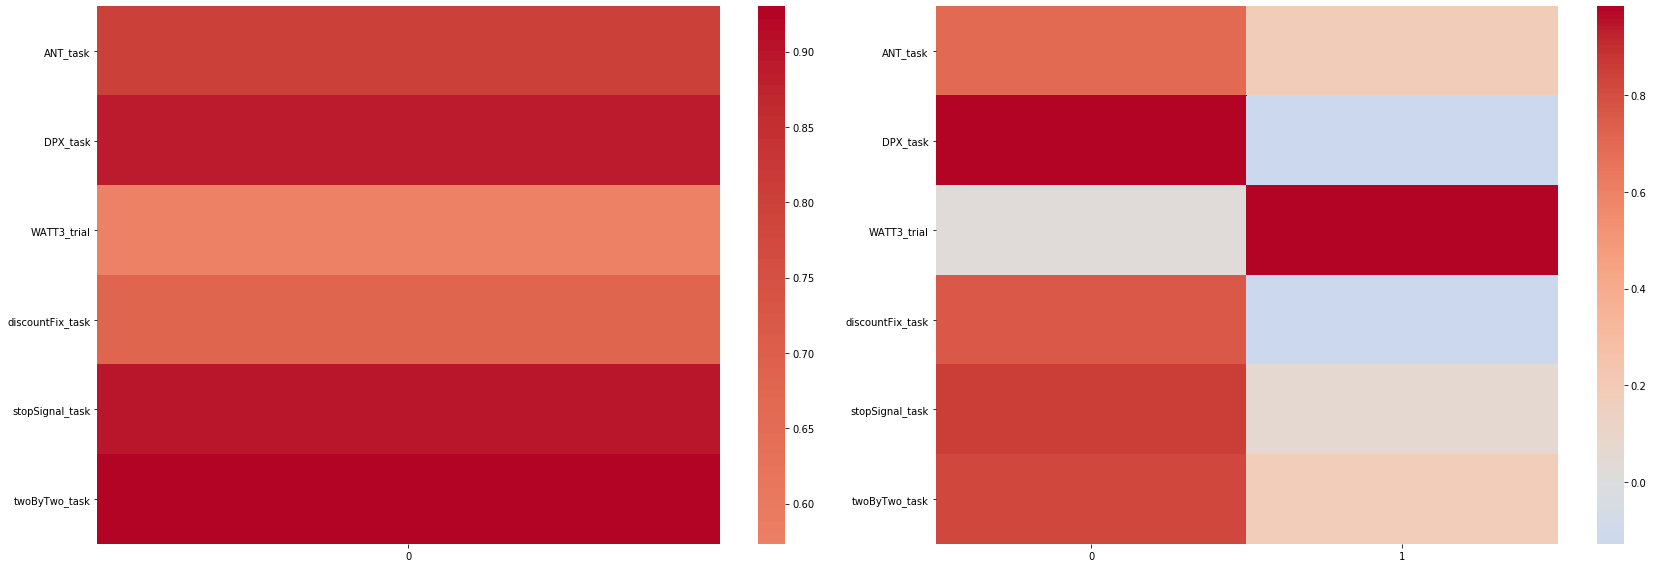

esfMRI [2] [12.92290586]
400 [2] [7.23683321]
500 [2] [17.86899518]
600 [2] [27.29198376]
800 [2] [38.17225218]
1000 [2] [55.78980587]


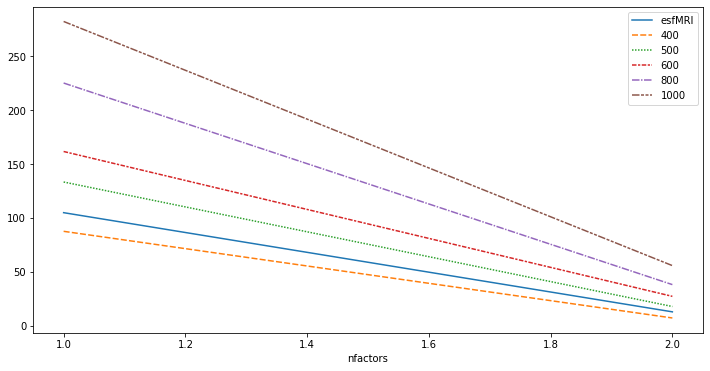

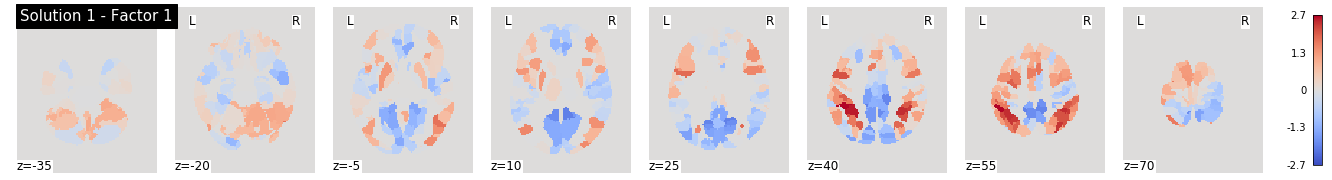

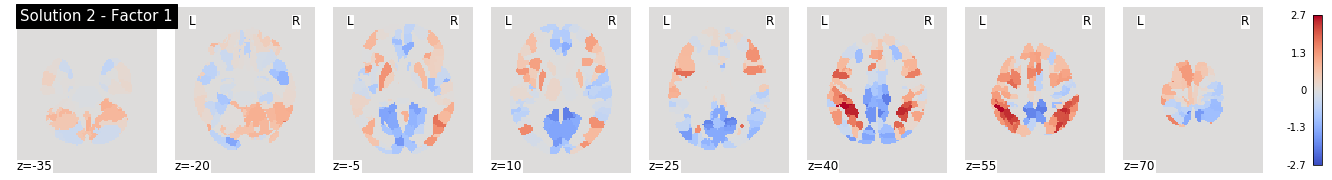

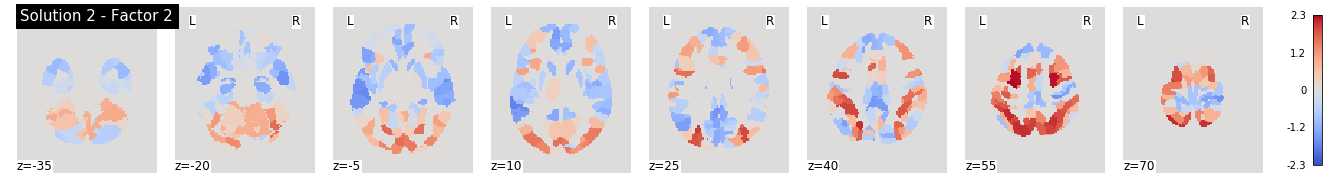

In [10]:
info_dict, BIC_df = pipeline(TASK_BETA_MAPS_EXPANDED, split_str=EXPANDED_SPLIT_STR, nfac_plot=[1,2])

## ALL CONTRASTS - NO TASK > BASELINE

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 15 contrasts which were correlated above 0.85
DPX_BY	motorSelectiveStop_noncrit_signal	twoByTwo_cue_stay_100	stopSignal_go	motorSelectiveStop_go_RT	stopSignal_stop_failure	DPX_AY	motorSelectiveStop_crit_stop_success	stopSignal_stop_failure-go	motorSelectiveStop_crit_stop_success-crit_go	twoByTwo_cue_stay	motorSelectiveStop_crit_go	DPX_BX	motorSelectiveStop_crit_stop_failure	twoByTwo_RT


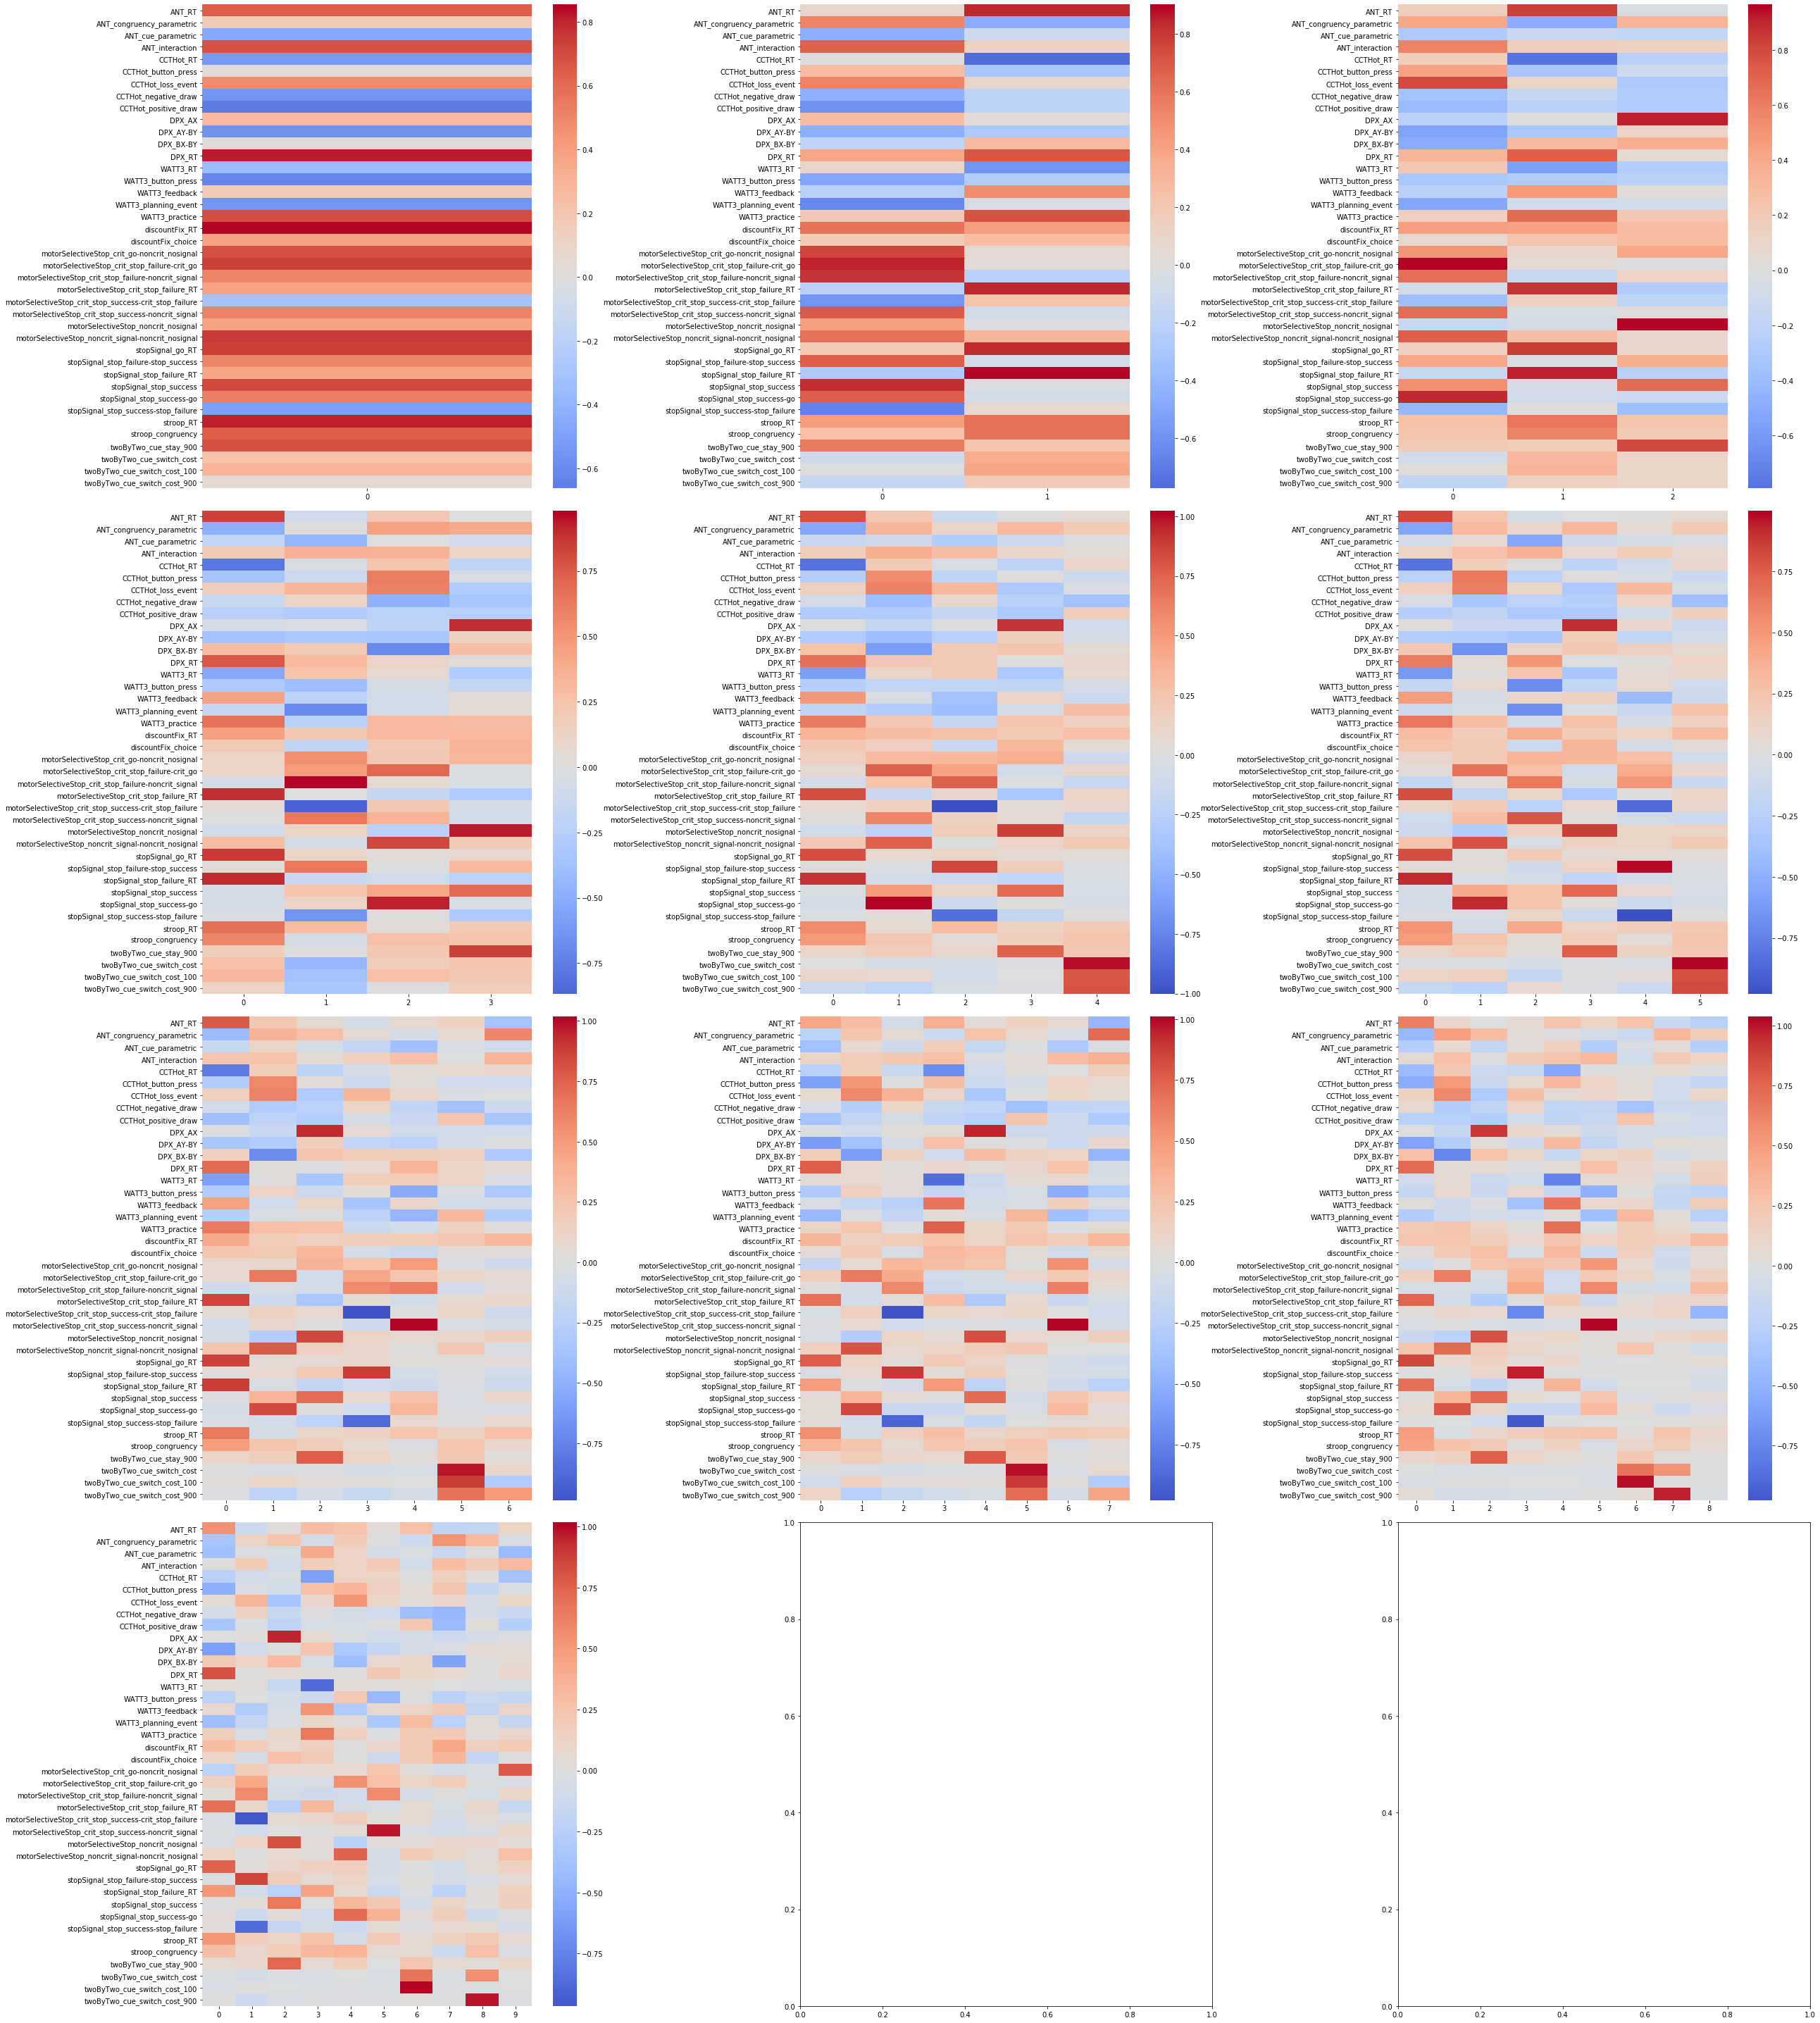

esfMRI [9] [9267.99457763]
400 [9] [8391.87167943]
500 [9] [11042.31082605]
600 [10] [14215.0491617]
800 [10] [19310.23087422]
1000 [10] [24756.06601644]


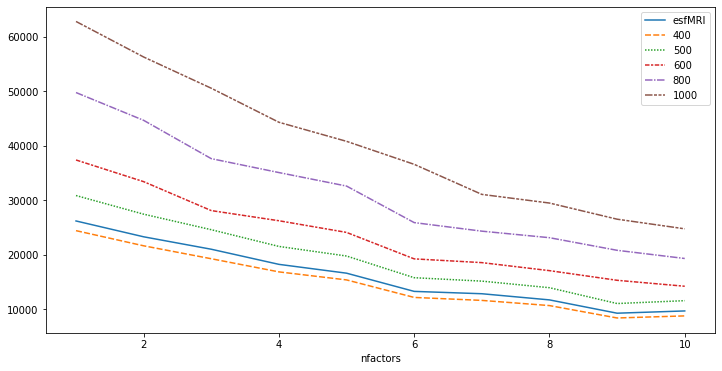

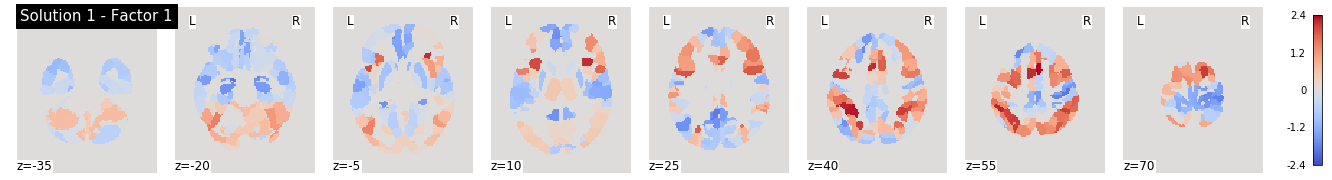

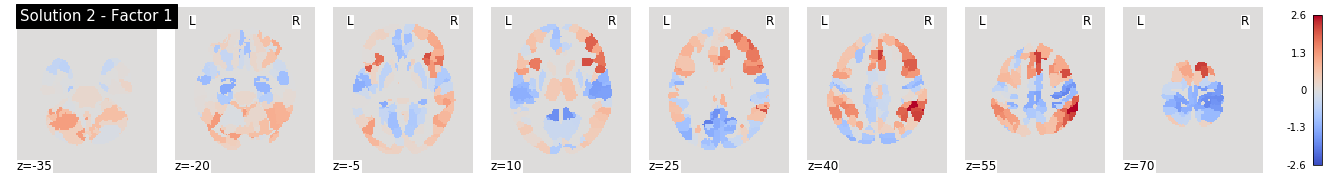

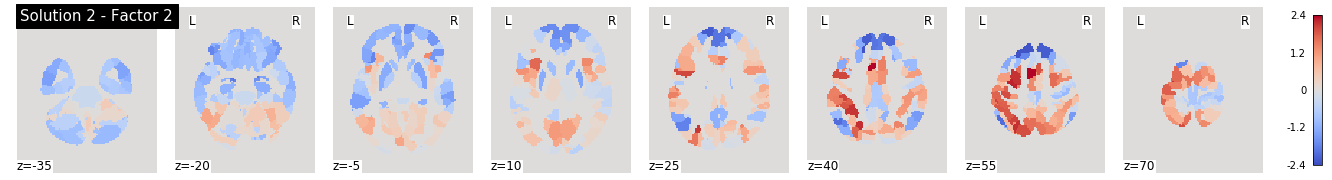

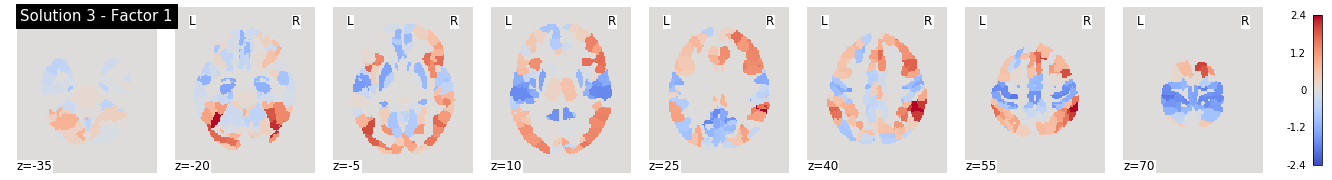

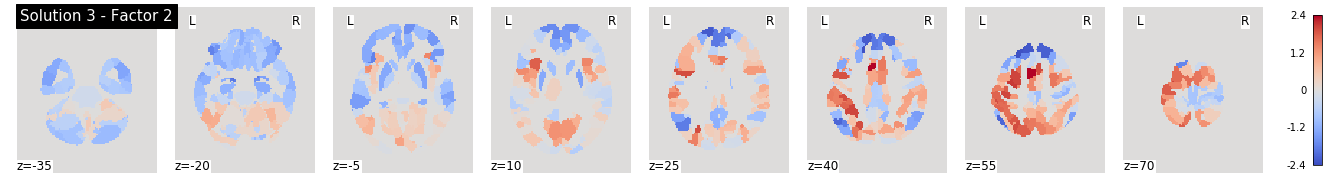

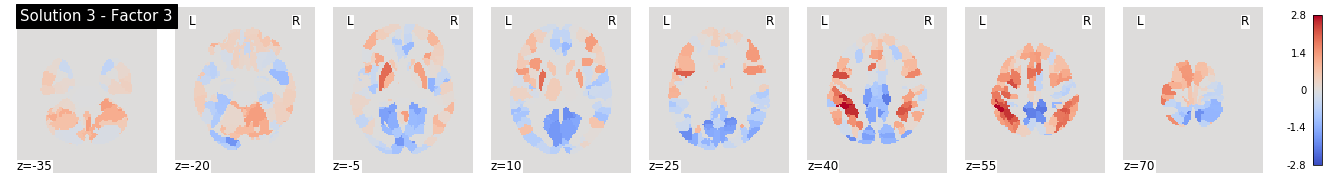

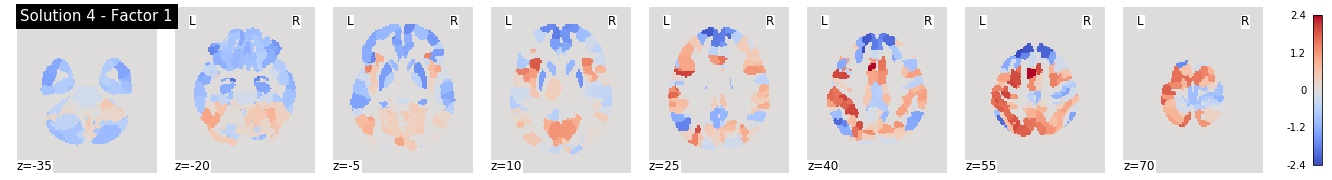

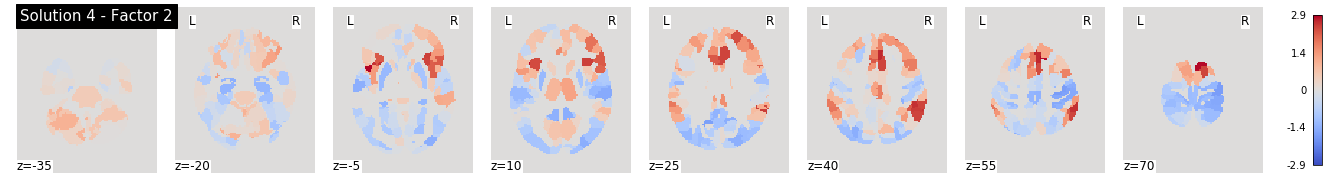

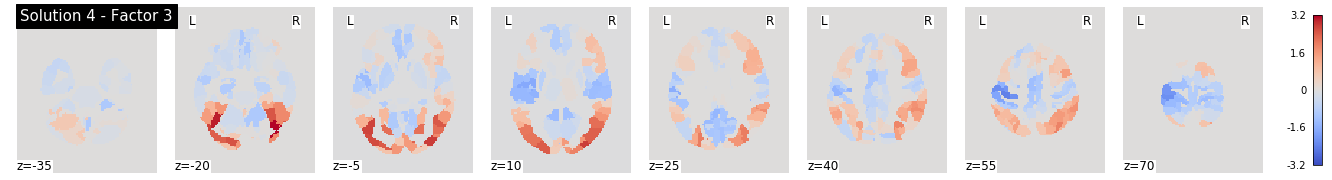

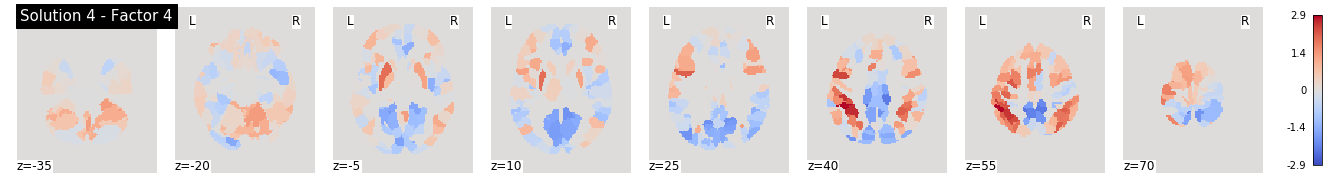

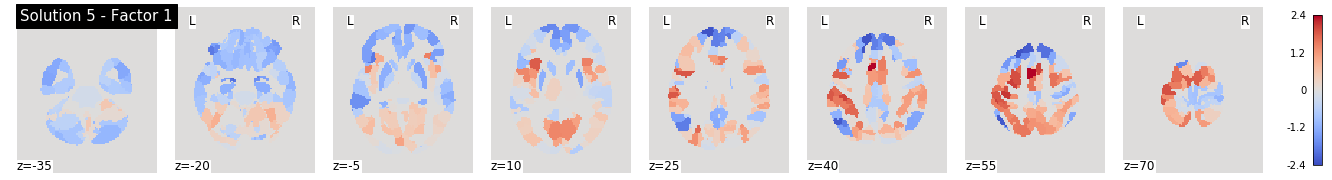

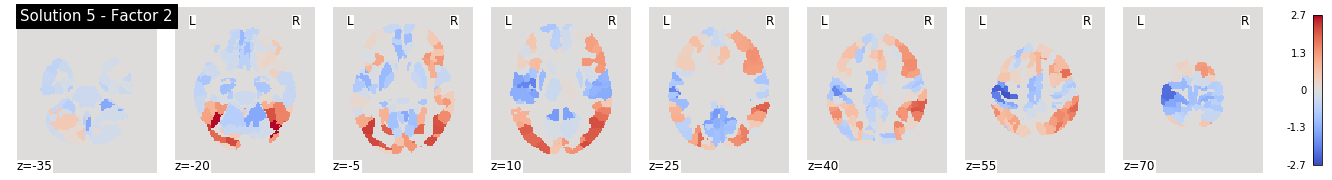

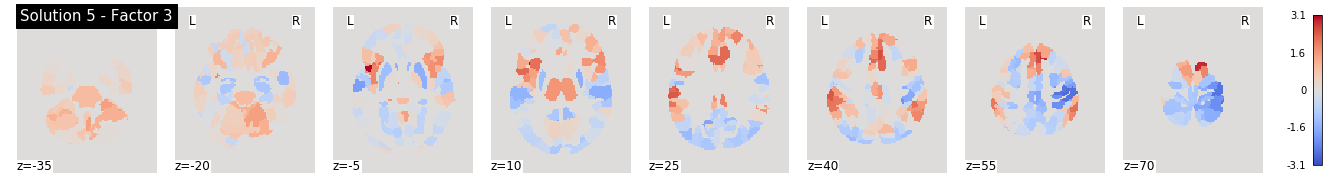

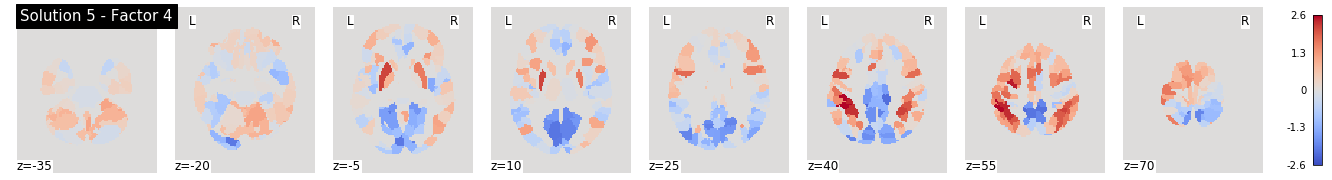

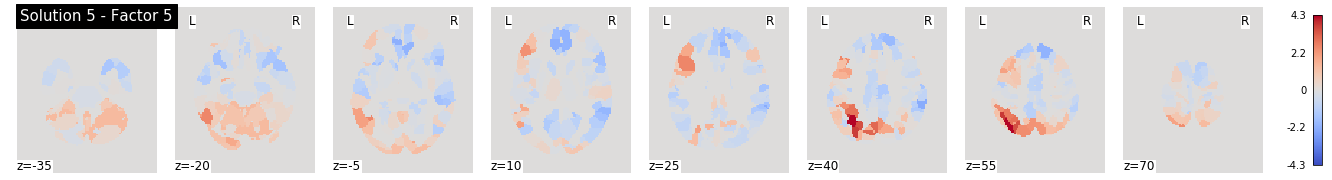

In [11]:
info_dict, BIC_df = pipeline([i for i in ALL_BETA_MAPS_EXPANDED if ('task' not in i) and ('trial' not in i)], split_str=EXPANDED_SPLIT_STR)

## ALL CONTRASTS - TASKS INCLUDED

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 28 contrasts which were correlated above 0.85
motorSelectiveStop_task	twoByTwo_cue_stay_100	motorSelectiveStop_noncrit_signal	twoByTwo_cue_stay	twoByTwo_cue_stay_900	twoByTwo_task	stopSignal_go	twoByTwo_task_switch	twoByTwo_task_stay_cue_switch	DPX_task	stopSignal_task	twoByTwo_task_switch_900	motorSelectiveStop_go_RT	twoByTwo_task_stay_cue_switch_900	DPX_BX	stopSignal_stop_failure	DPX_AY	motorSelectiveStop_crit_stop_success	twoByTwo_task_switch_100	stopSignal_stop_failure-go	WATT3_trial	motorSelectiveStop_

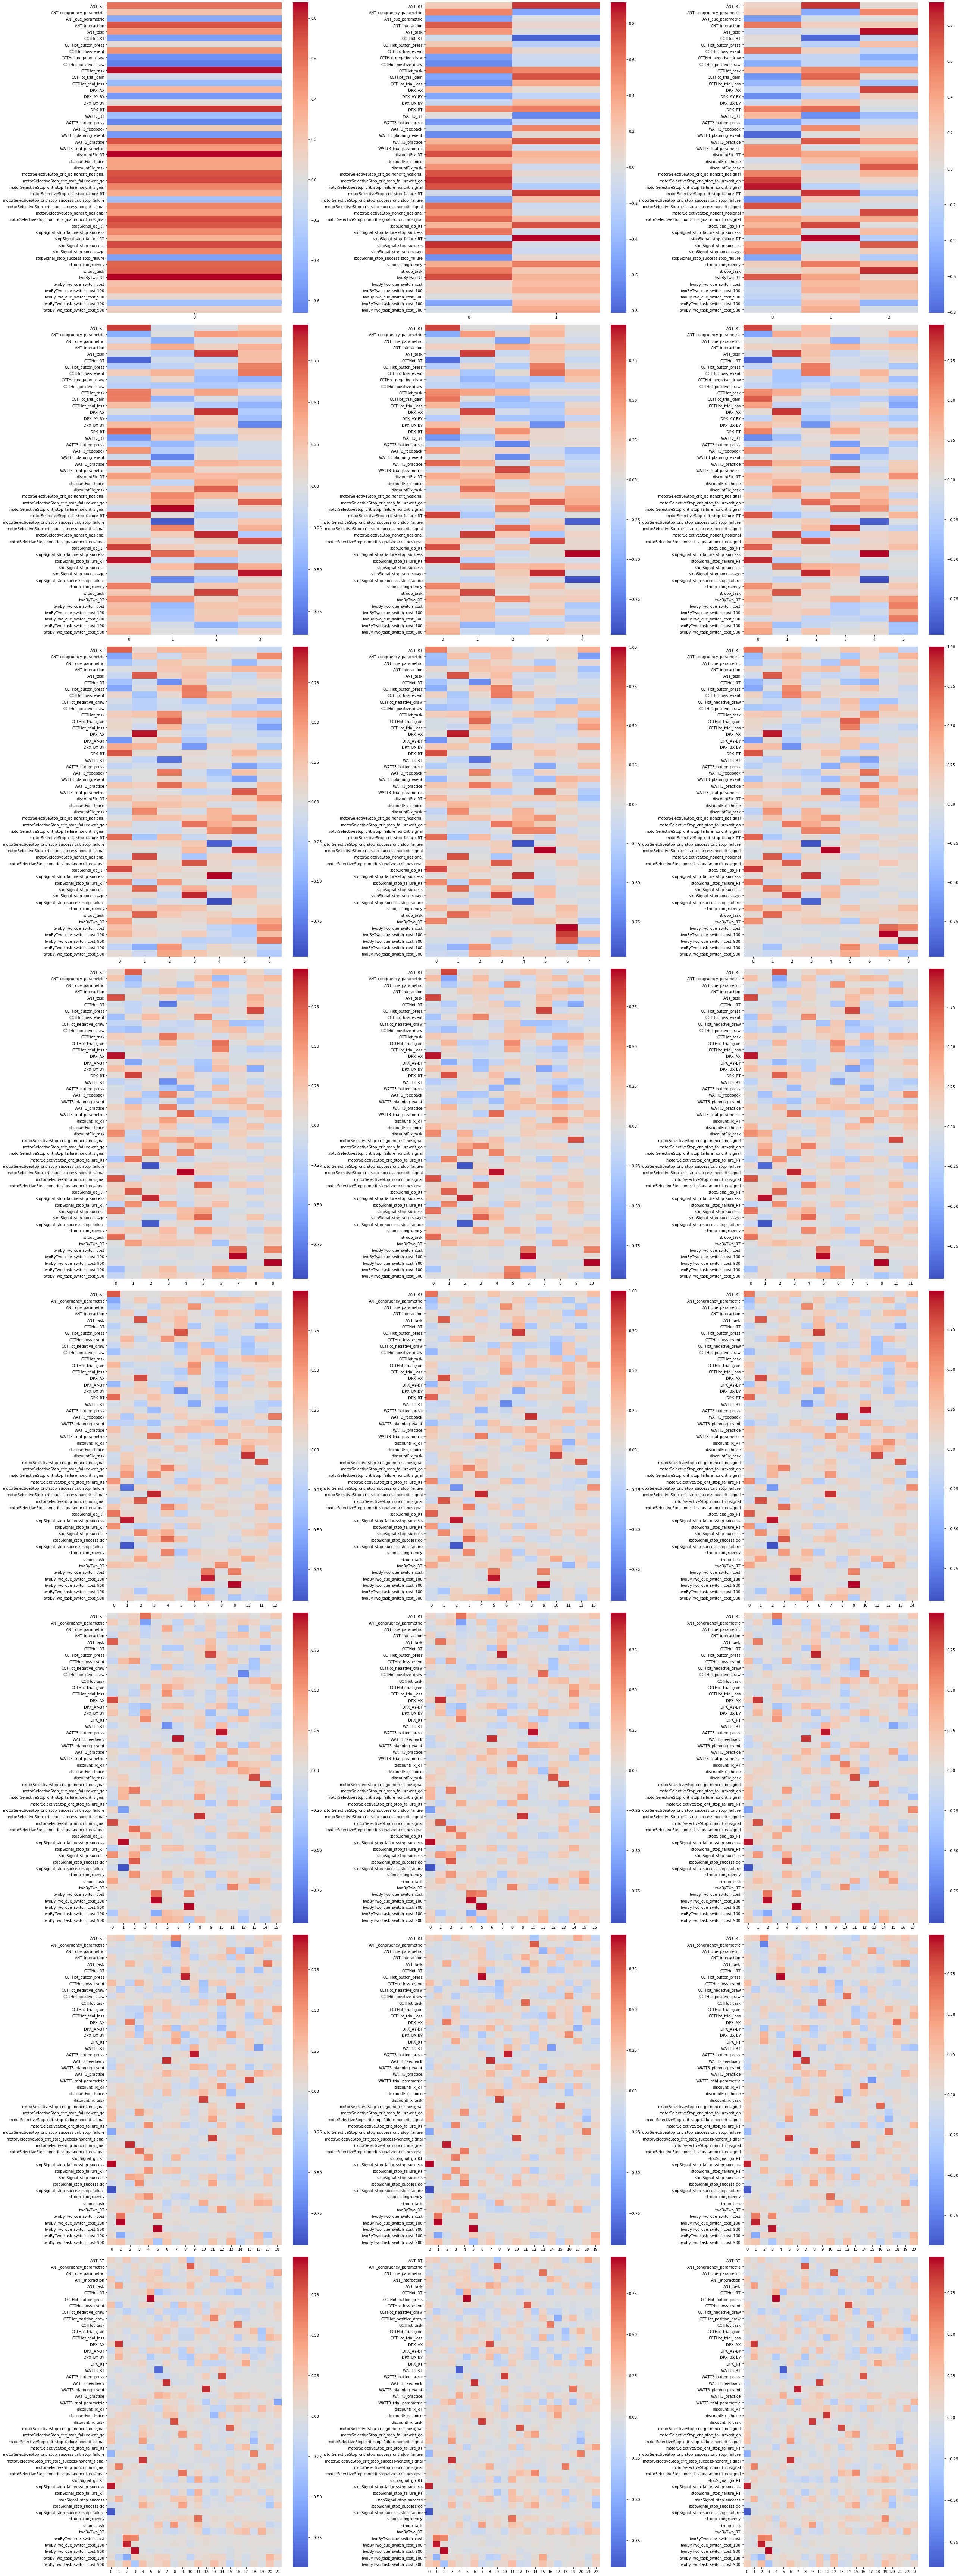

esfMRI [22] [5312.02525351]
400 [23] [4722.99561037]
500 [24] [6523.78975484]
600 [24] [7864.94677729]
800 [24] [10903.93711613]
1000 [24] [14008.87846932]


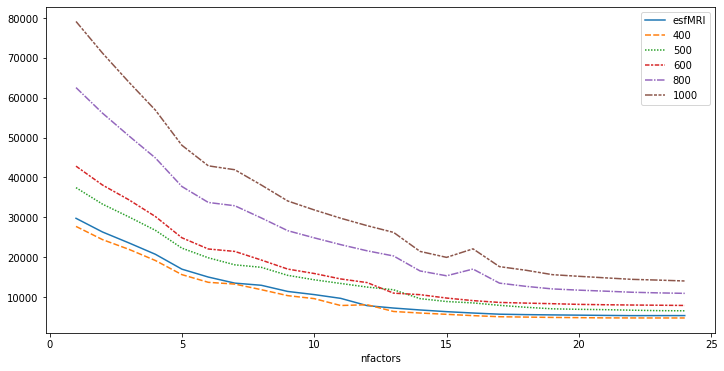

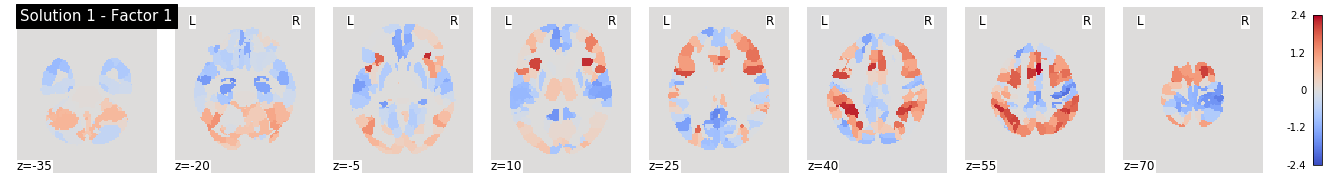

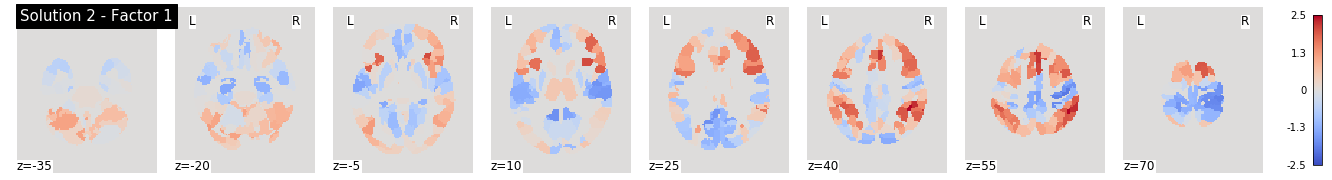

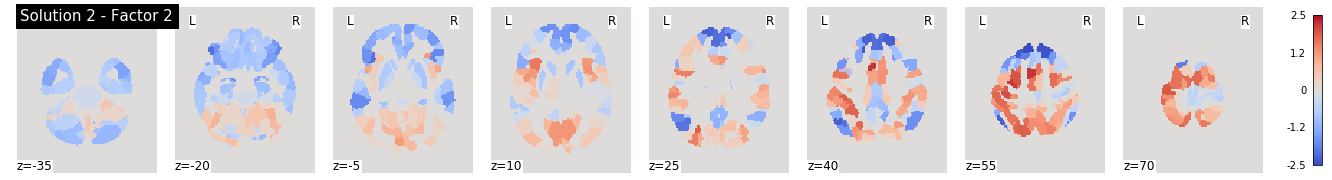

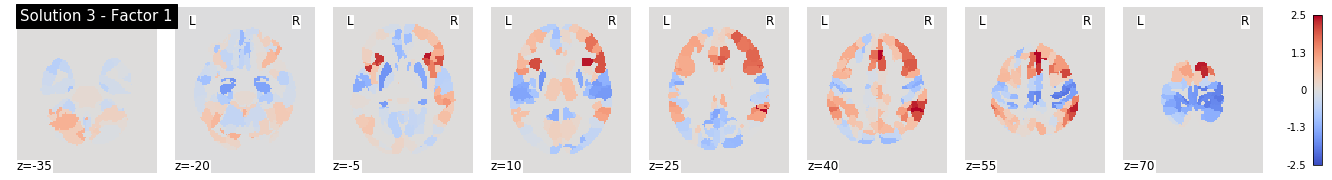

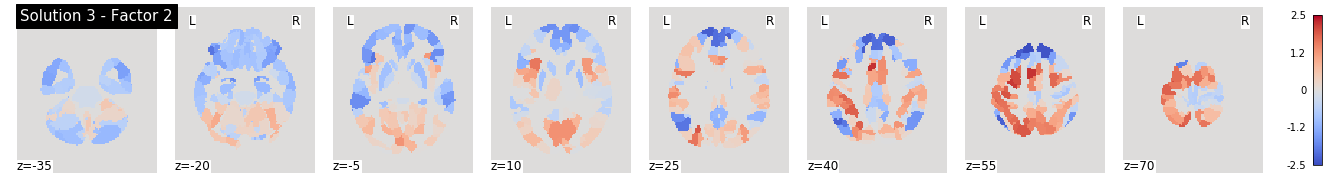

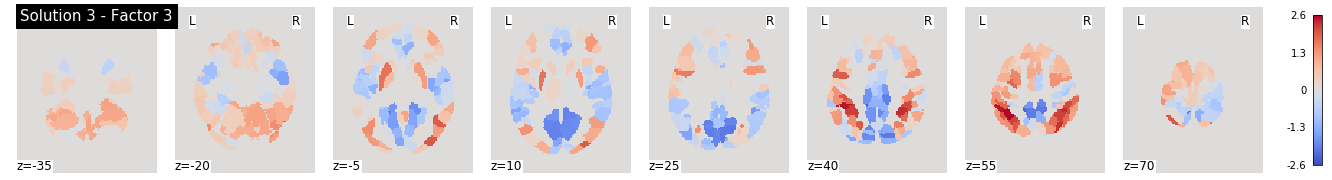

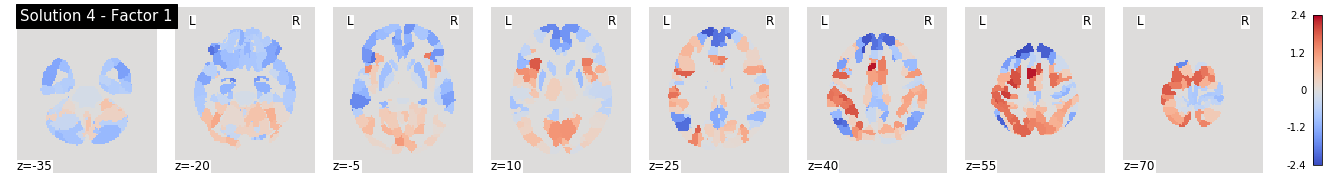

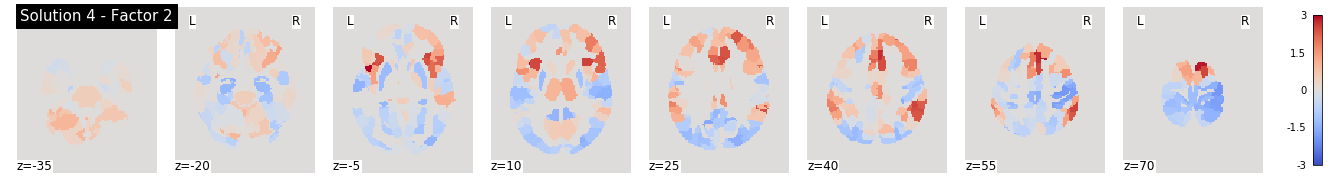

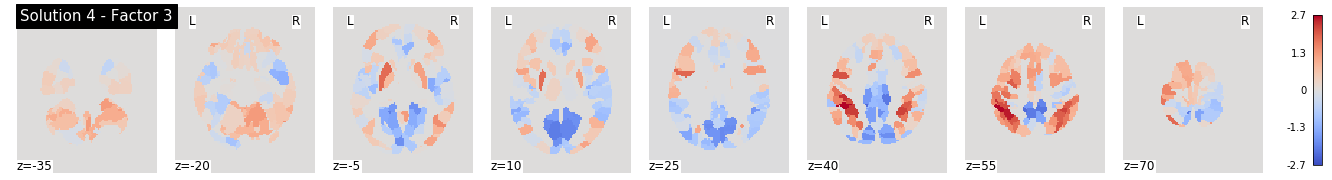

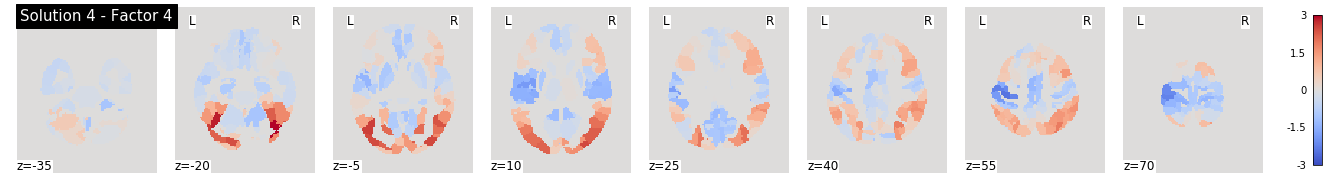

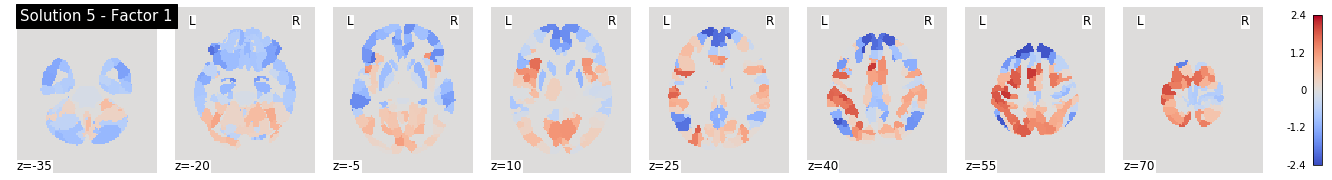

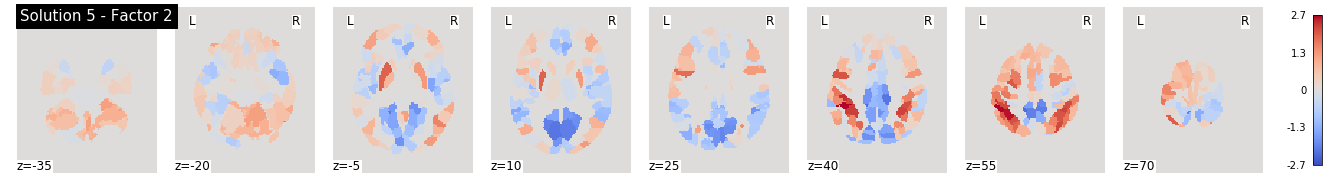

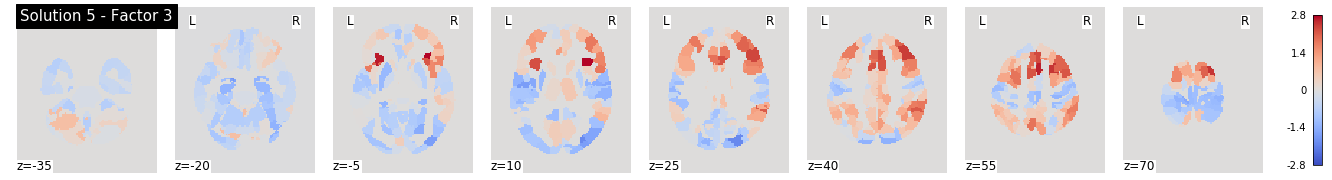

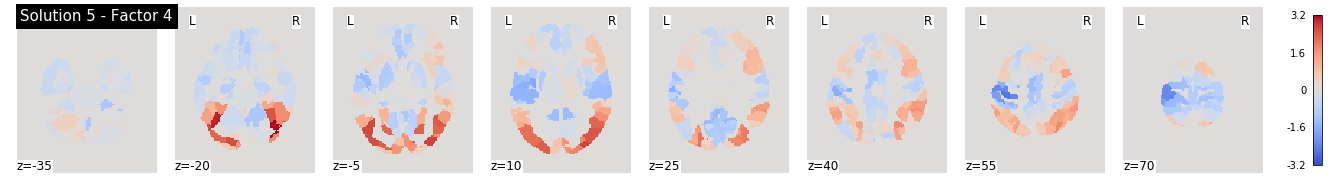

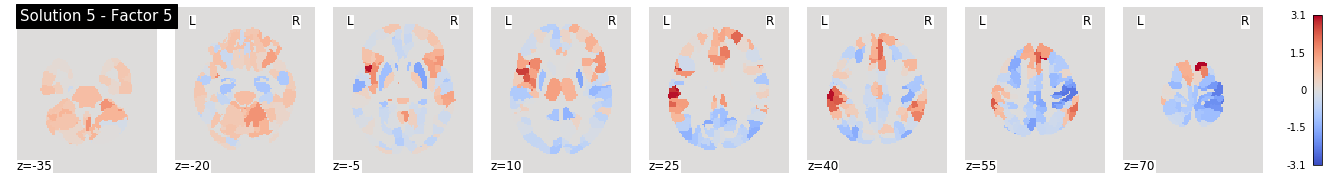

In [12]:
info_dict, BIC_df = pipeline(ALL_BETA_MAPS_EXPANDED, factor_options=np.arange(1,25,1), split_str=EXPANDED_SPLIT_STR)

## ALL CONTRASTS - NO EXCLUSIONS

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:


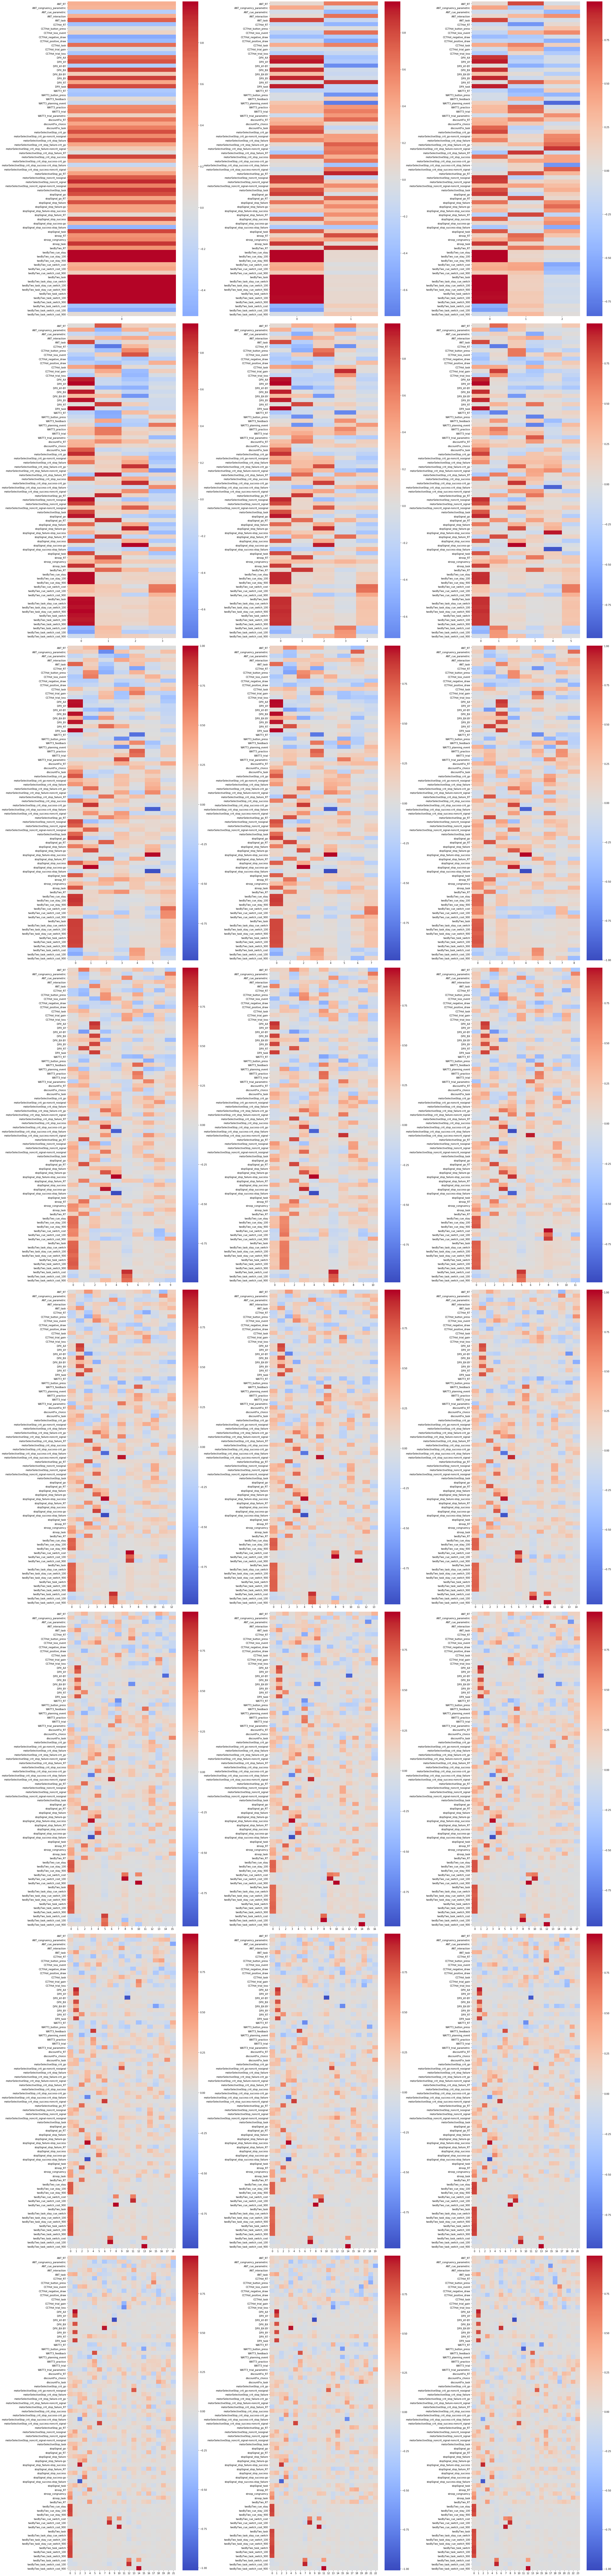

esfMRI [24] [9766.88032128]
400 [24] [8429.27710218]
500 [24] [11888.46555427]
600 [24] [15436.13524136]
800 [24] [22008.02881459]
1000 [24] [28811.12777308]


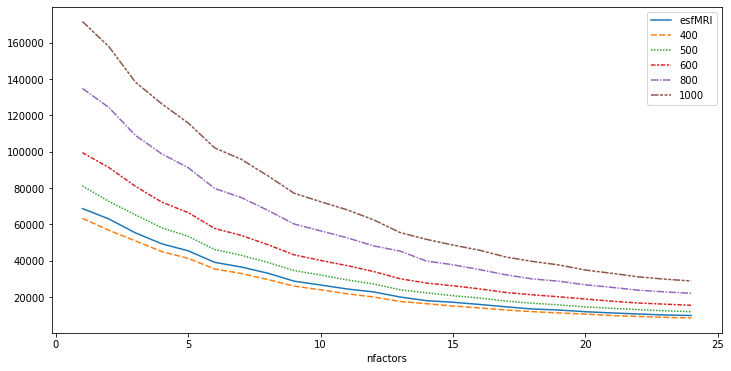

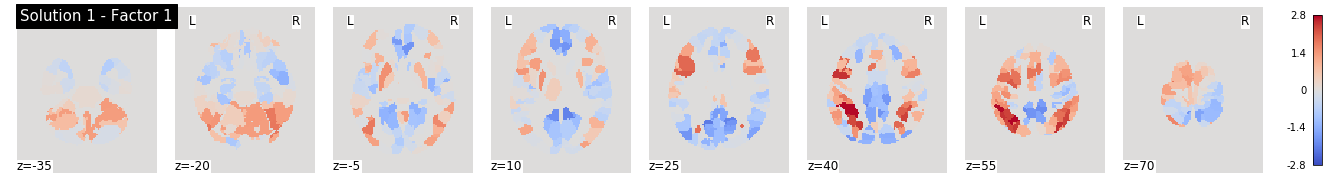

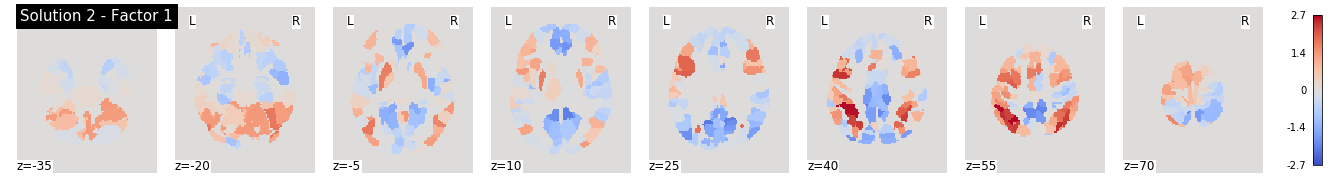

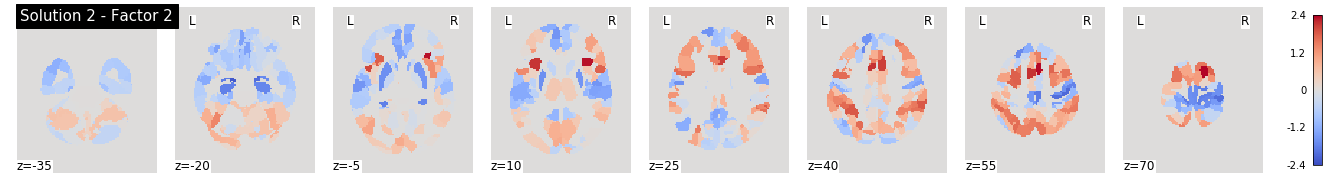

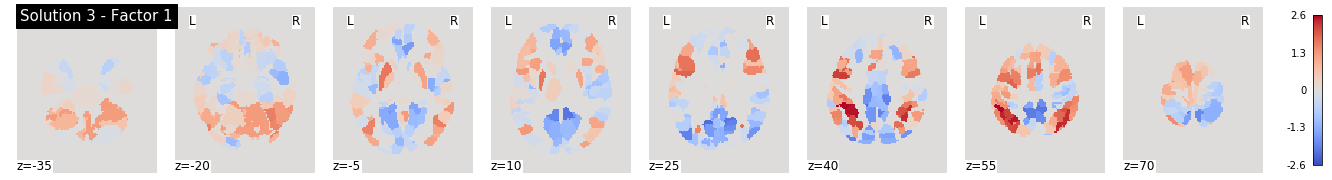

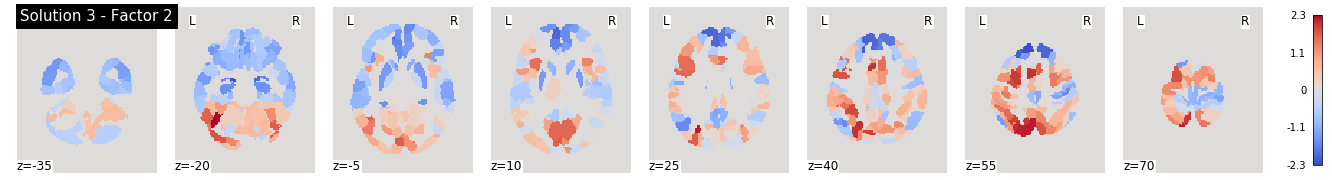

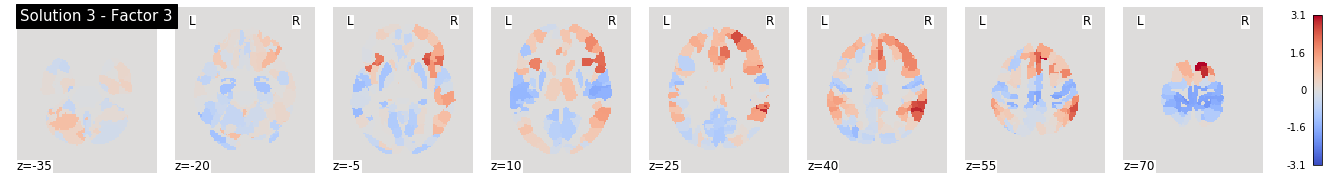

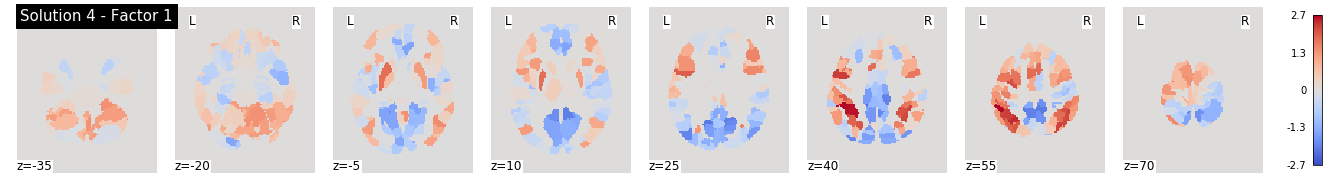

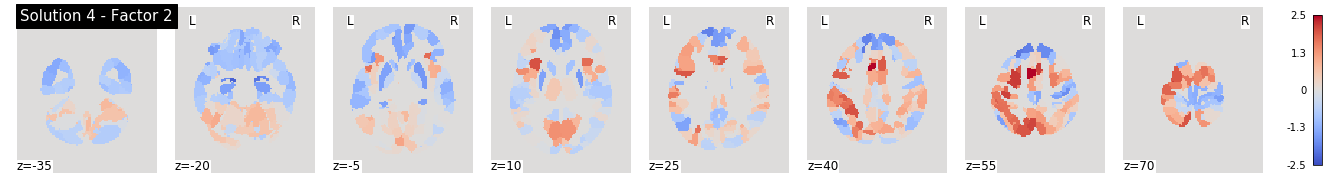

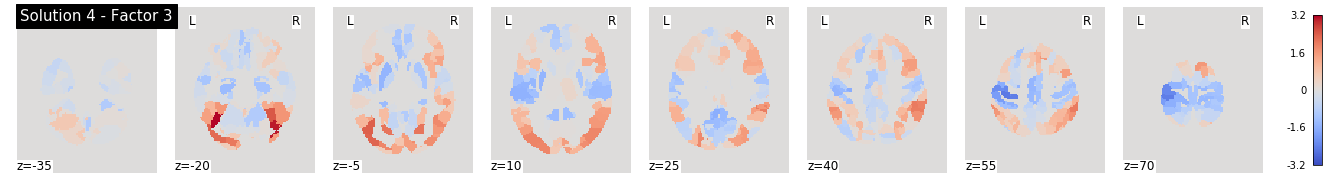

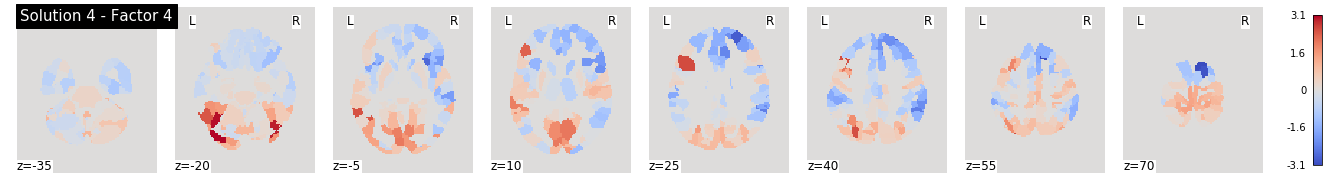

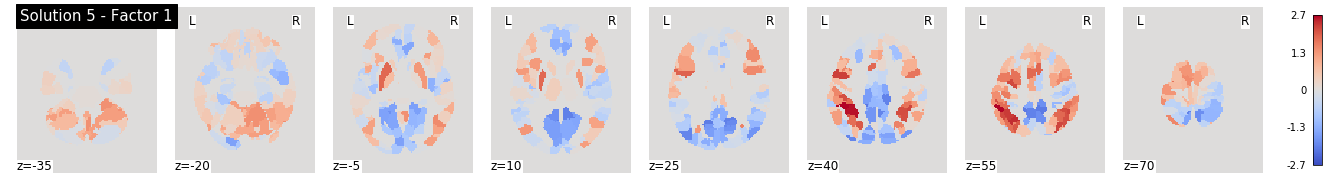

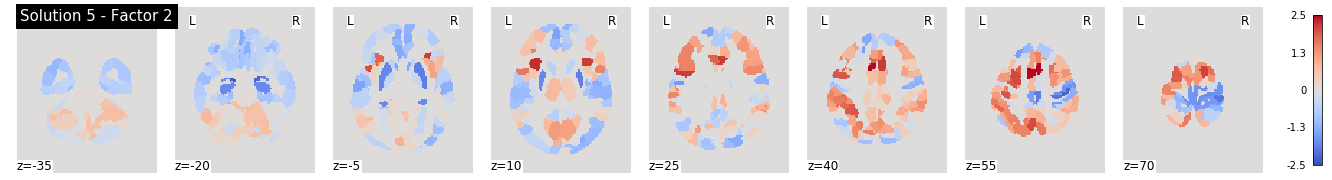

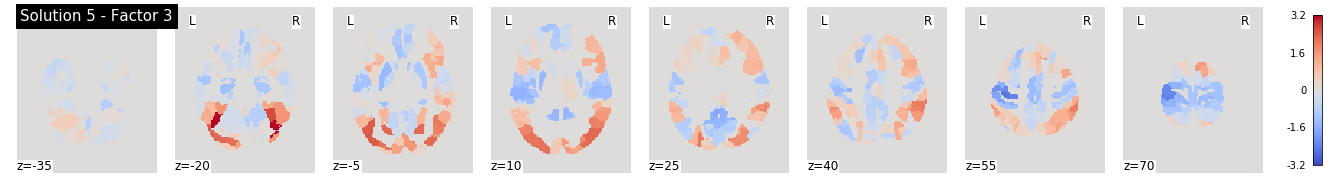

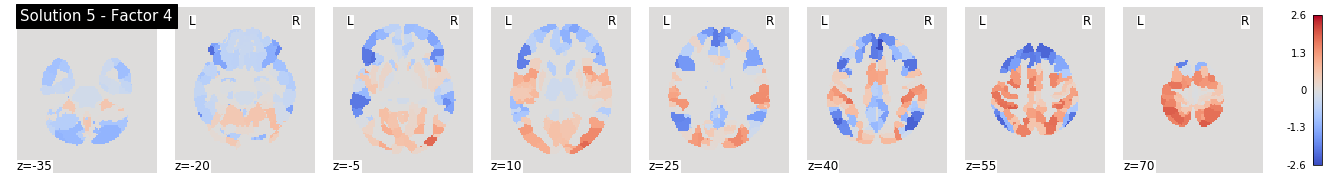

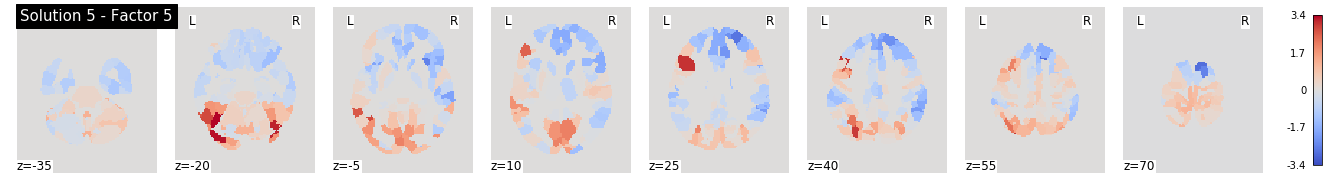

In [13]:
info_dict, BIC_df = pipeline(ALL_BETA_MAPS_EXPANDED, factor_options=np.arange(1,25,1), split_str=EXPANDED_SPLIT_STR, check_correlations=False)

# __STREAMLINED [NEWEST MAPS]__

In [14]:
TASK_BETA_MAPS = glob(path.join(BASEDIR, f'*/*RT-{RT_FLAG}*/*contrast-task.nii.gz')) + glob(path.join(BASEDIR, f'*/*RT-{RT_FLAG}*/*contrast-trial.nii.gz'))

ALL_BETA_MAPS = glob(path.join(BASEDIR, f'*/*RT-{RT_FLAG}*/*contrast-*.nii.gz'))
ALL_BETA_MAPS = [i for i in ALL_BETA_MAPS if 'tfile' not in i]

SPLIT_STR = '2ndlevel/'

In [15]:
ALL_BETA_MAPS_readable = [i.replace('/Users/henrymj/Documents/SRO/tmp/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/', '').replace('secondlevel-RT-True_beta-False_maps/', '') for i in ALL_BETA_MAPS]
print('\n'.join(ALL_BETA_MAPS_readable))

WATT3/contrast-trial.nii.gz
WATT3/contrast-RT.nii.gz
stroop/contrast-task.nii.gz
stroop/contrast-RT.nii.gz
motorSelectiveStop/contrast-noncrit_nosignal.nii.gz
motorSelectiveStop/contrast-task.nii.gz
motorSelectiveStop/contrast-crit_stop_failure-noncrit_signal.nii.gz
motorSelectiveStop/contrast-crit_stop_failure-crit_go.nii.gz
motorSelectiveStop/contrast-crit_stop_success-crit_go.nii.gz
motorSelectiveStop/contrast-crit_go.nii.gz
motorSelectiveStop/contrast-crit_stop_success-noncrit_signal.nii.gz
motorSelectiveStop/contrast-crit_stop_success.nii.gz
motorSelectiveStop/contrast-go_RT.nii.gz
motorSelectiveStop/contrast-crit_stop_success-crit_stop_failure.nii.gz
motorSelectiveStop/contrast-noncrit_signal.nii.gz
motorSelectiveStop/contrast-crit_go-noncrit_nosignal.nii.gz
motorSelectiveStop/contrast-noncrit_signal-noncrit_nosignal.nii.gz
motorSelectiveStop/contrast-crit_stop_failure.nii.gz
motorSelectiveStop/contrast-crit_stop_failure_RT.nii.gz
ANT/contrast-task.nii.gz
ANT/contrast-RT.nii.gz
C

## TASKS

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 2 contrasts which were correlated above 0.85
stopSignal_task	stroop_task


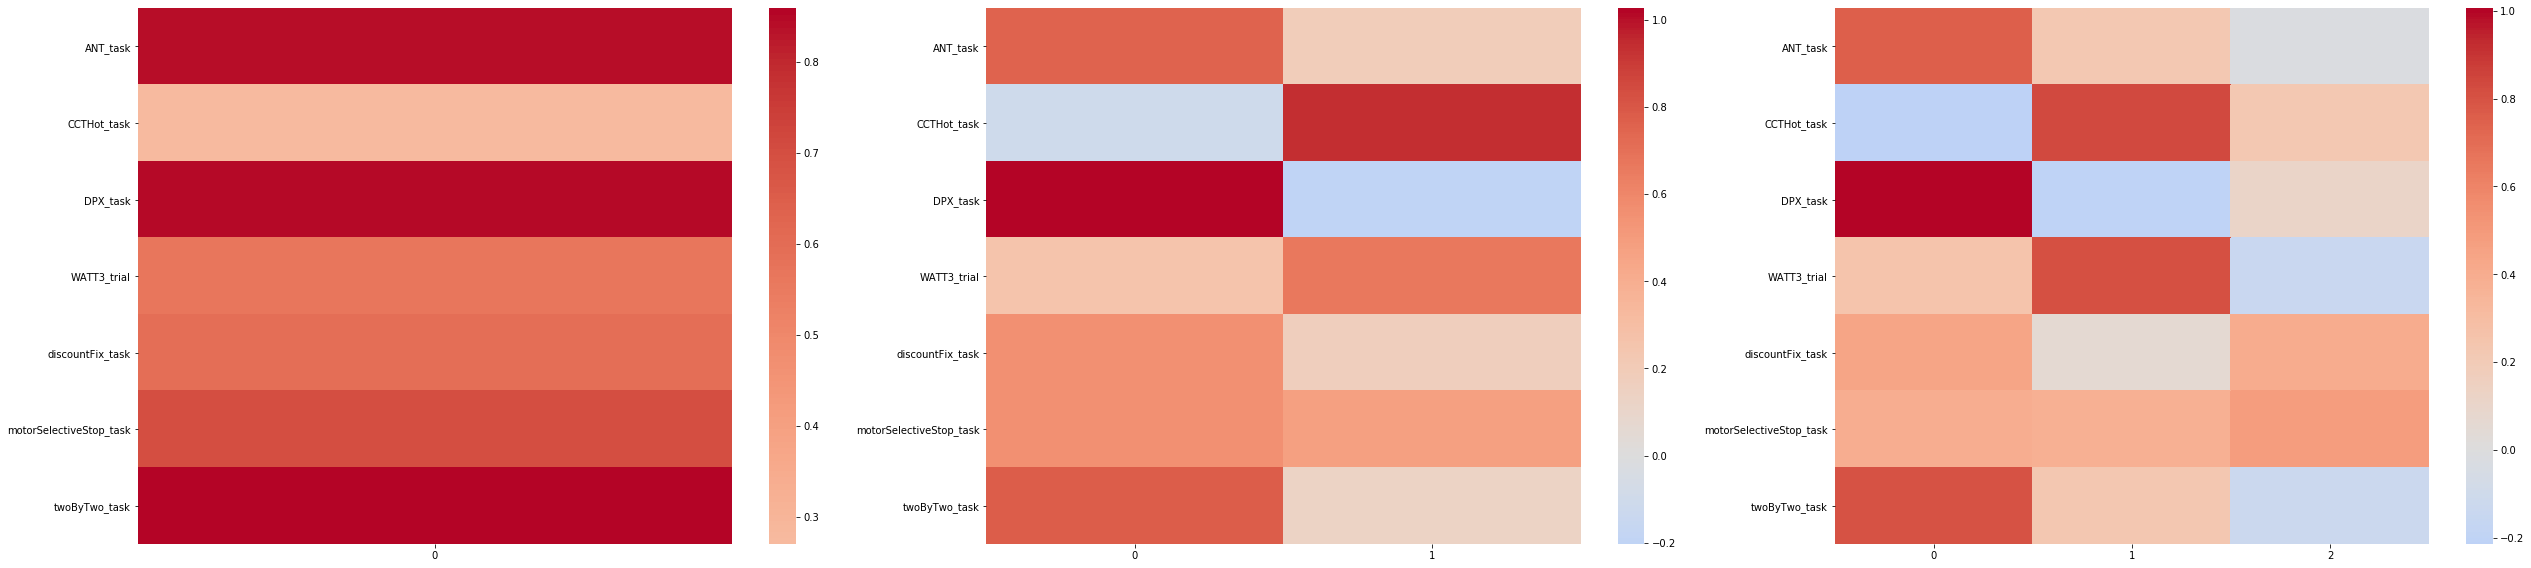

esfMRI [3] [9.252754]
400 [3] [11.36081513]
500 [3] [18.22760843]
600 [3] [15.79378834]
800 [3] [27.60995881]
1000 [3] [34.8003749]


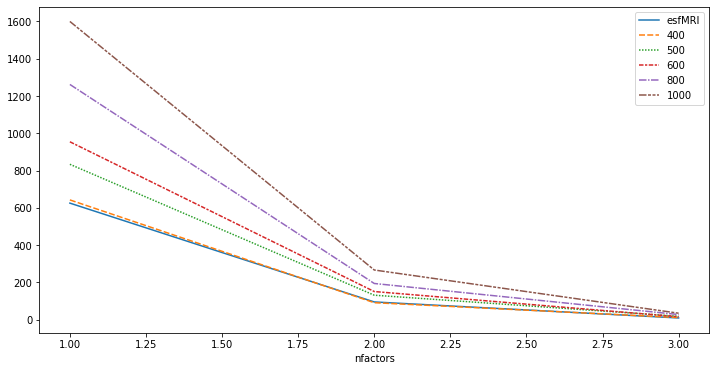

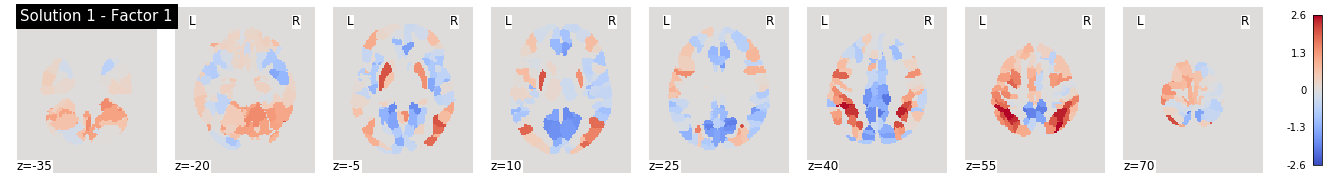

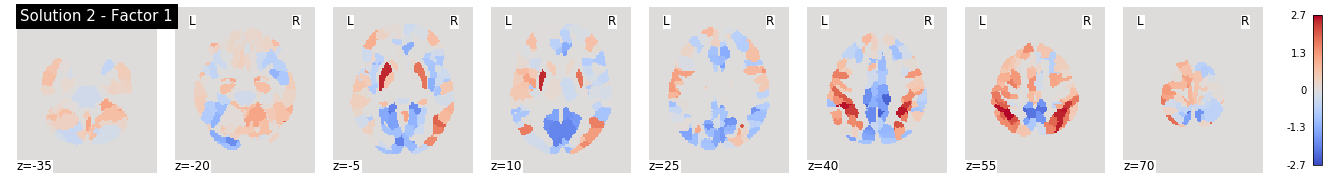

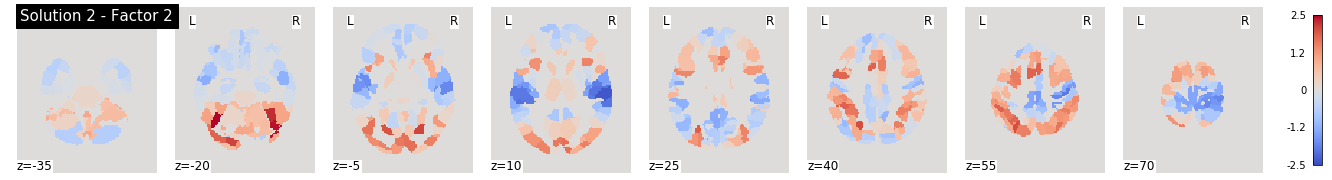

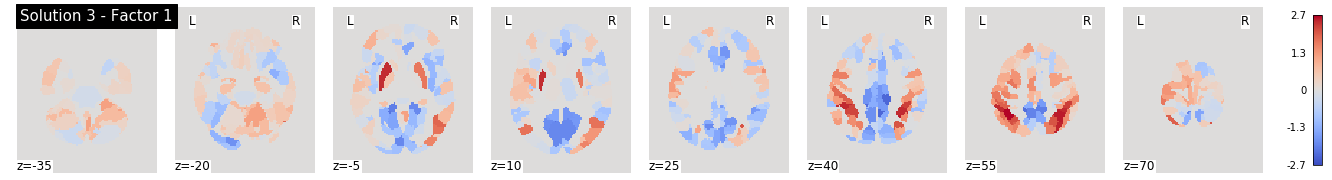

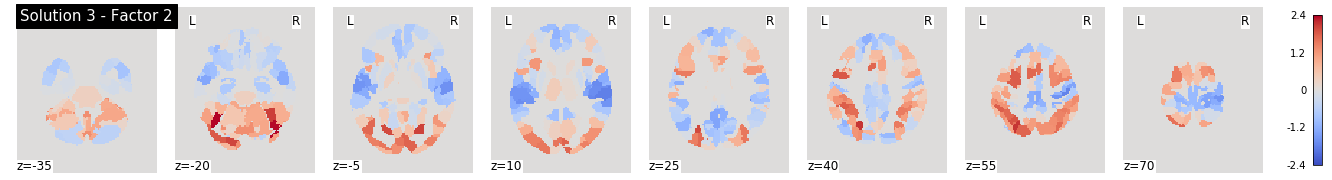

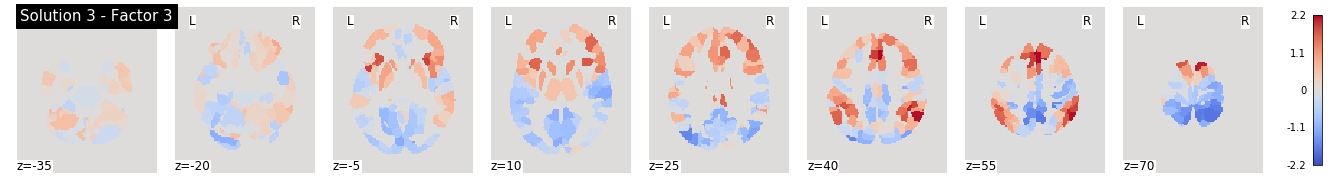

In [16]:
info_dict, BIC_df = pipeline(TASK_BETA_MAPS, split_str=SPLIT_STR, nfac_plot=np.arange(1,4,1))

## ALL CONTRASTS - NO TASK > BASELINE

****************************************
** Successfully transformed 1 positively skewed variables:
twoByTwo_cue_switch_cost
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 13 contrasts which were correlated above 0.85
motorSelectiveStop_crit_stop_success	motorSelectiveStop_go_RT	DPX_AY	twoByTwo_cue_stay	stopSignal_stop_failure	motorSelectiveStop_crit_go	stopSignal_stop_failure-go	motorSelectiveStop_crit_stop_success-crit_go	motorSelectiveStop_noncrit_signal	DPX_BX	twoByTwo_cue_stay_100	stroop_RT	stopSignal_go


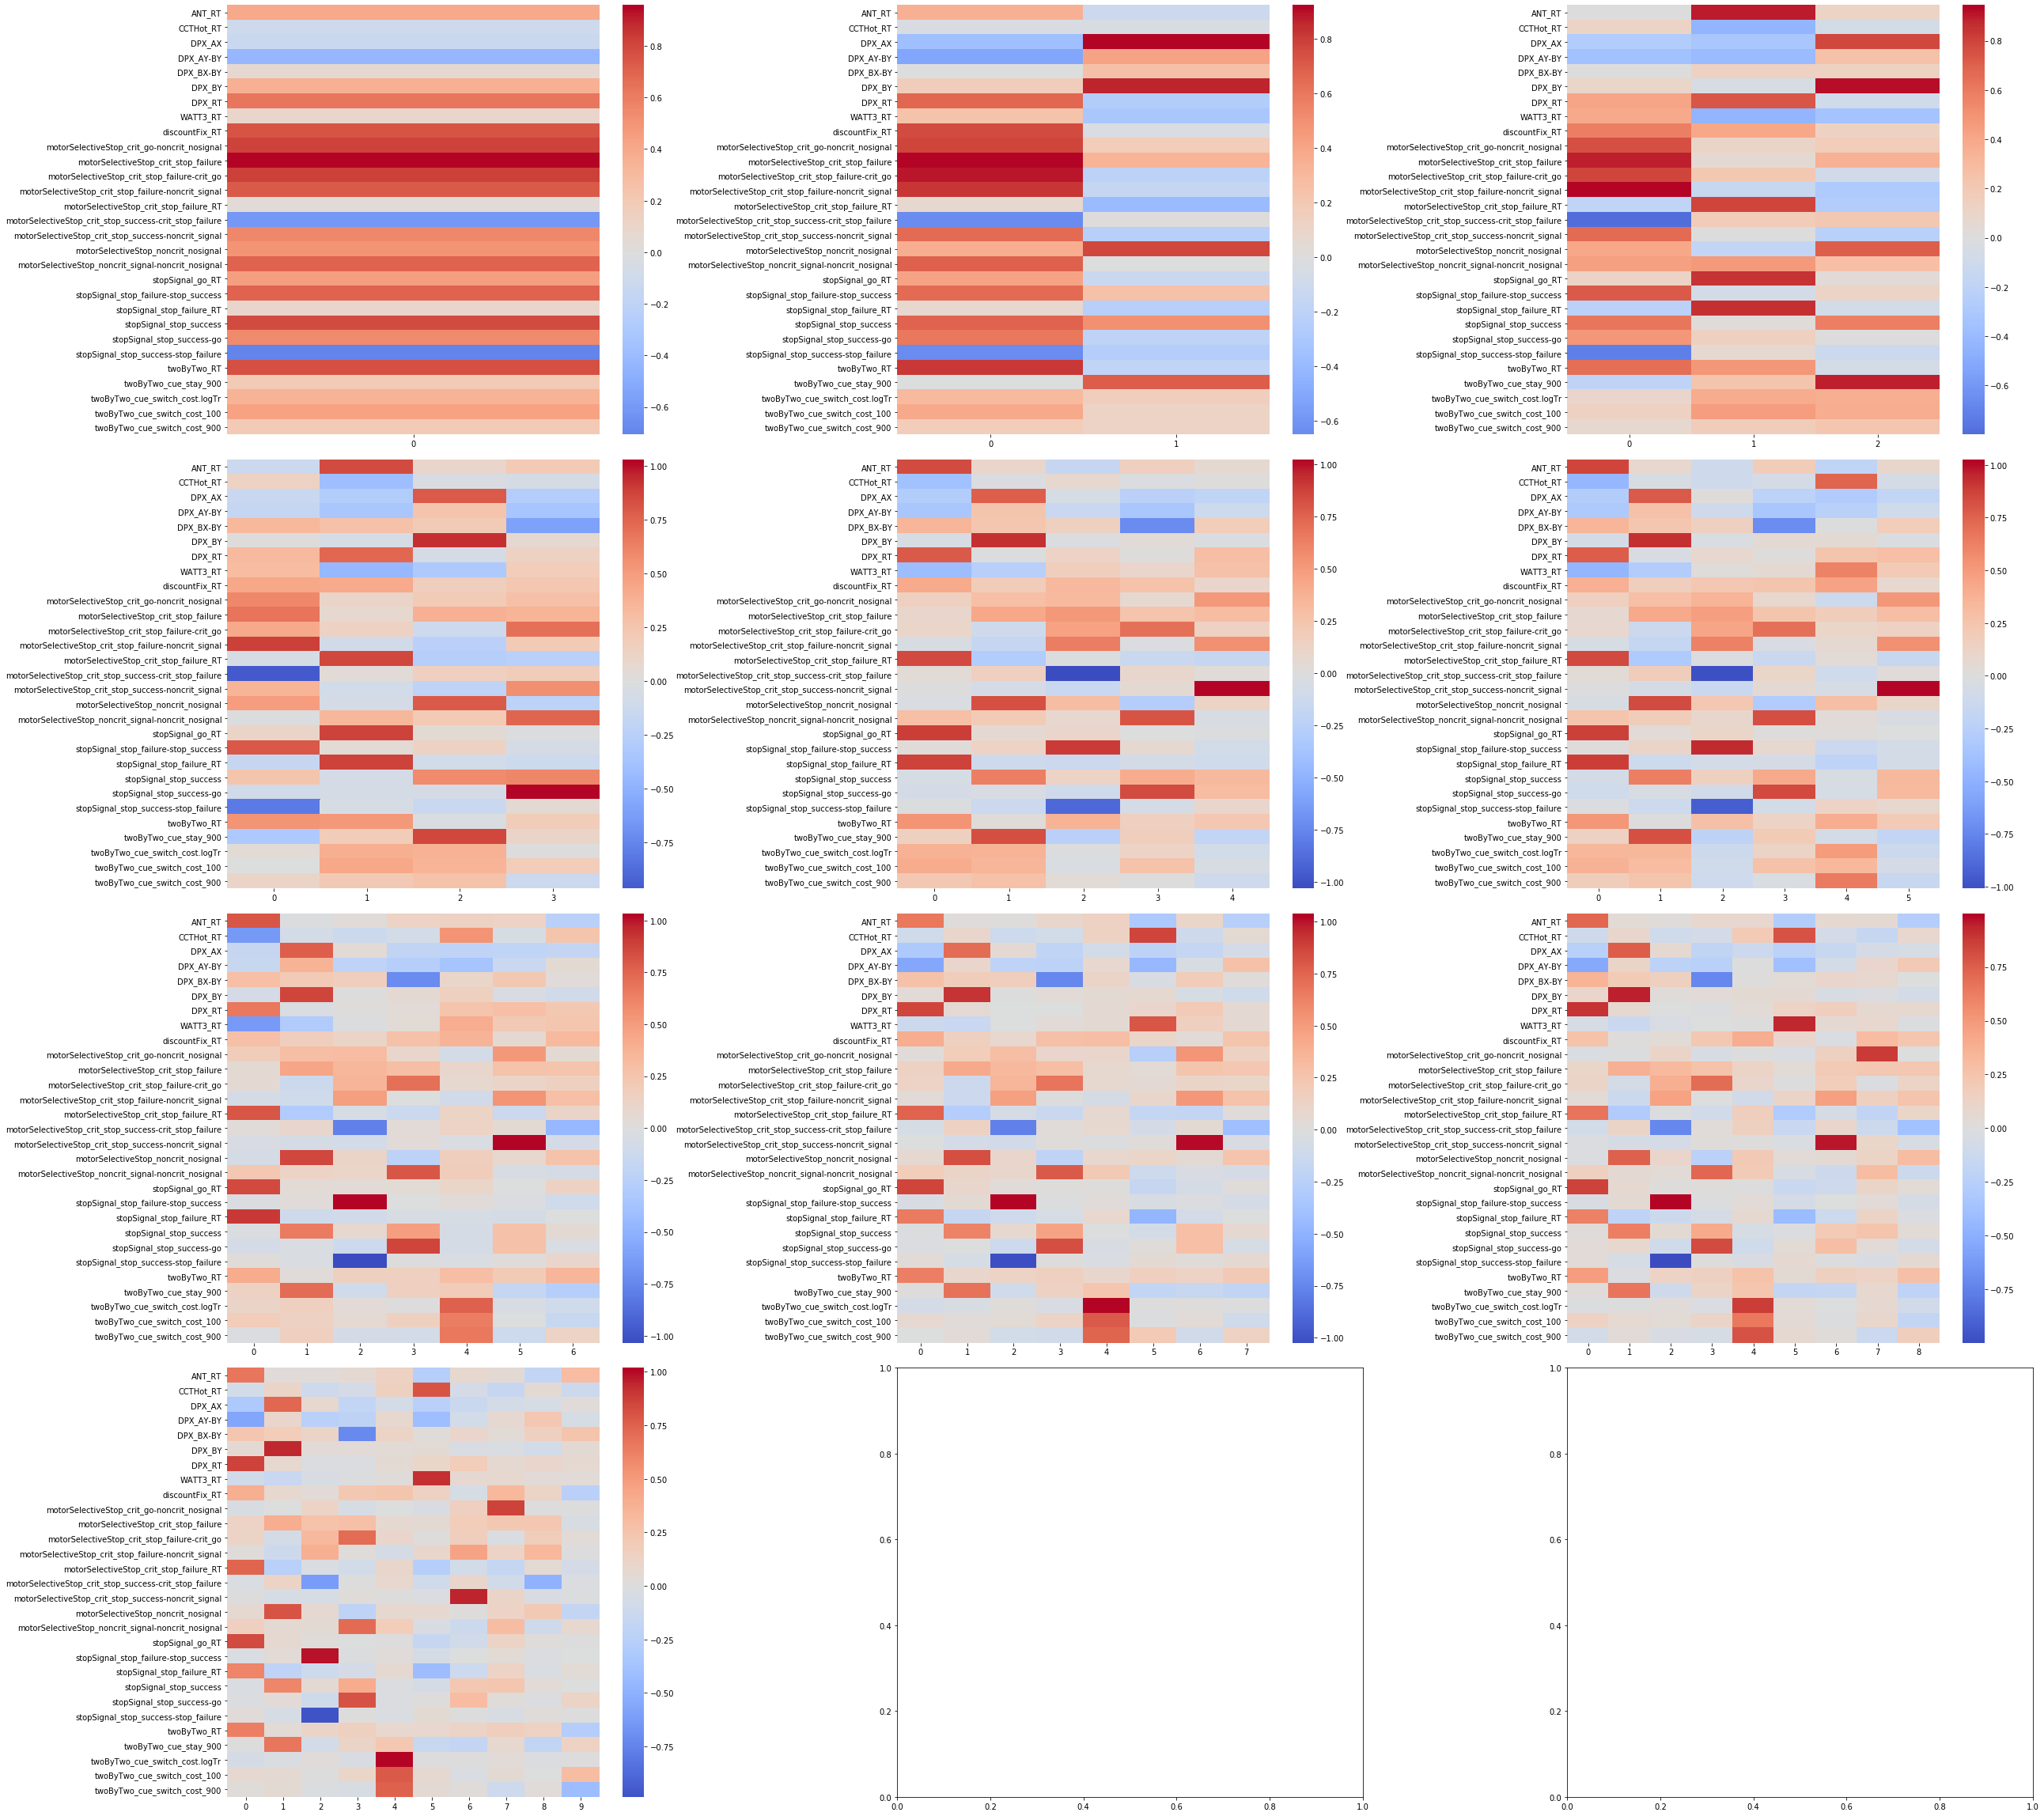

esfMRI [10] [7286.92587201]
400 [10] [6592.19915334]
500 [10] [8804.55988285]
600 [10] [10648.89916121]
800 [9] [15217.06787165]
1000 [10] [17909.59451539]


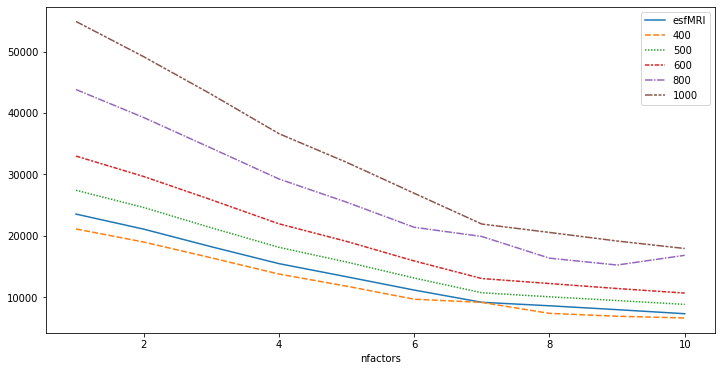

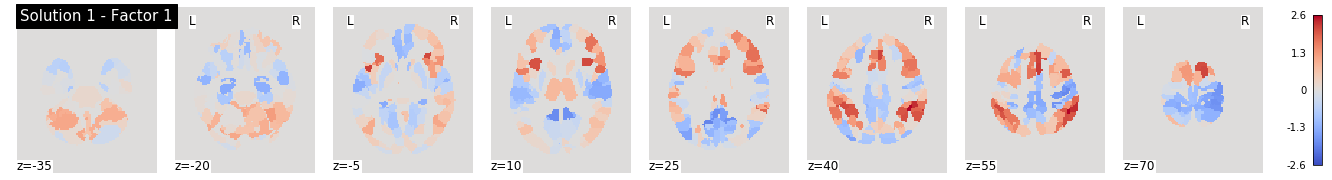

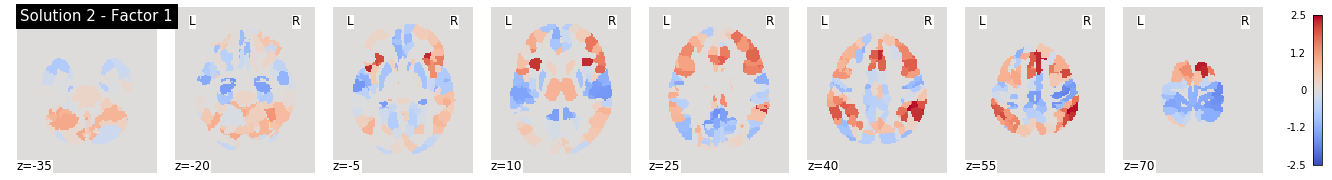

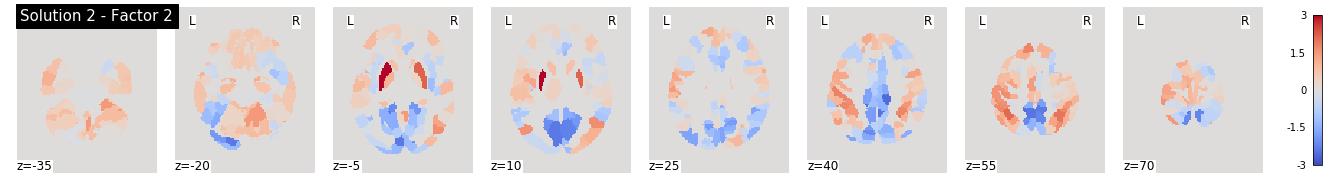

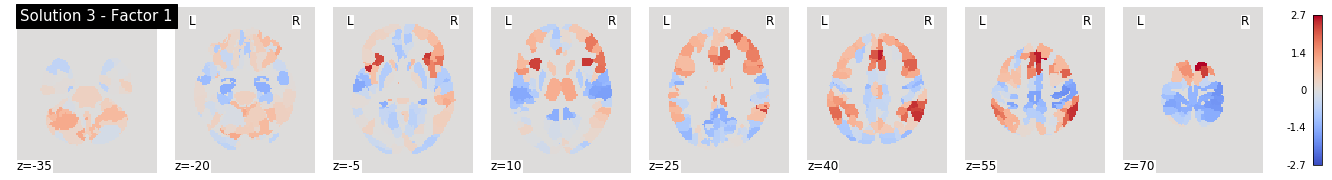

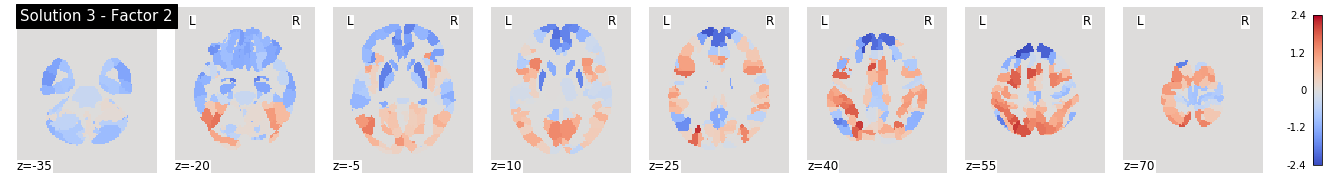

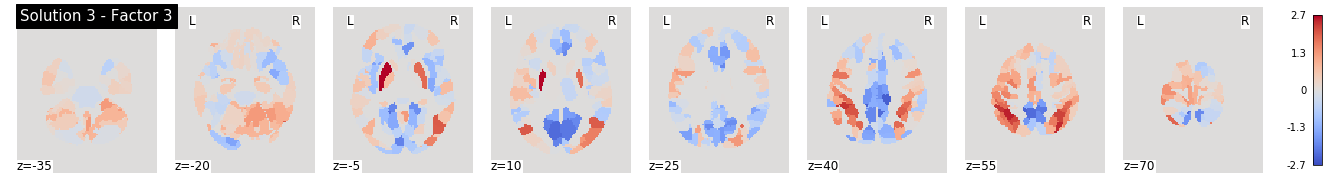

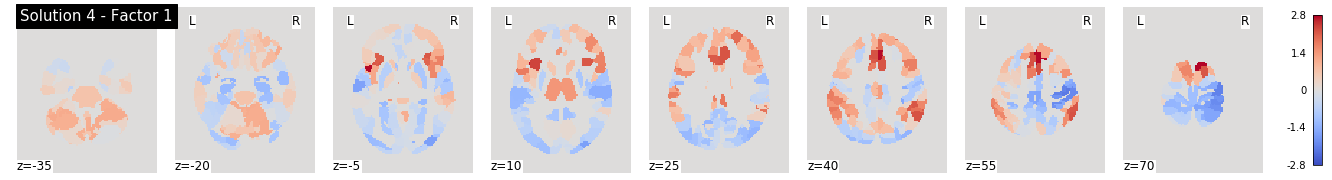

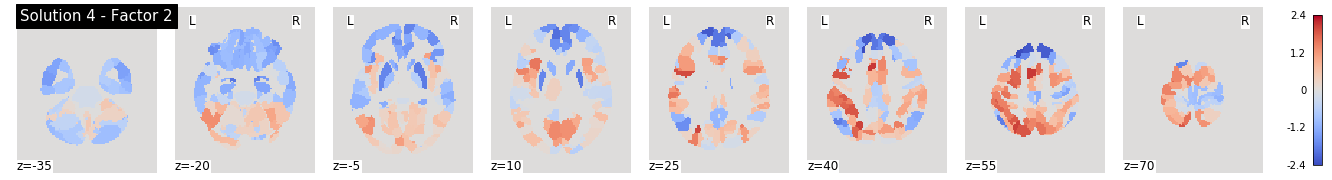

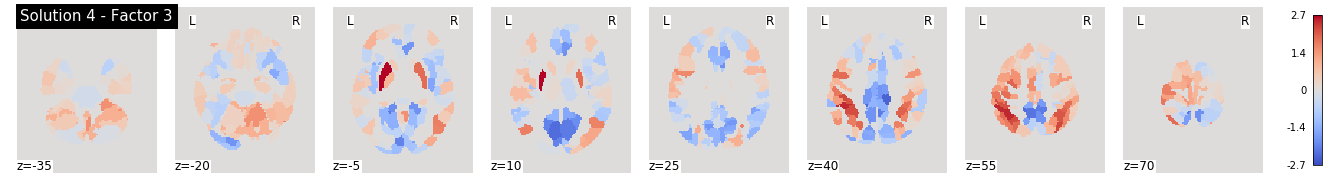

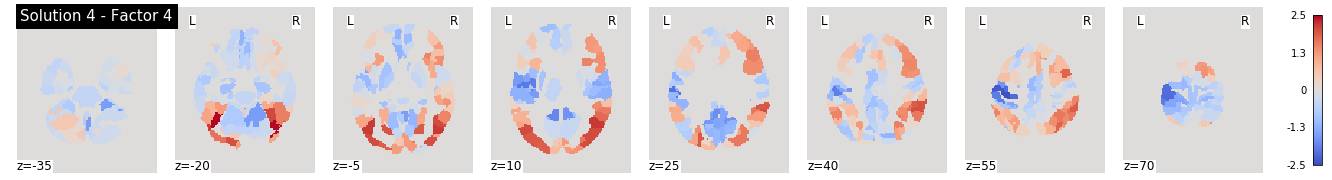

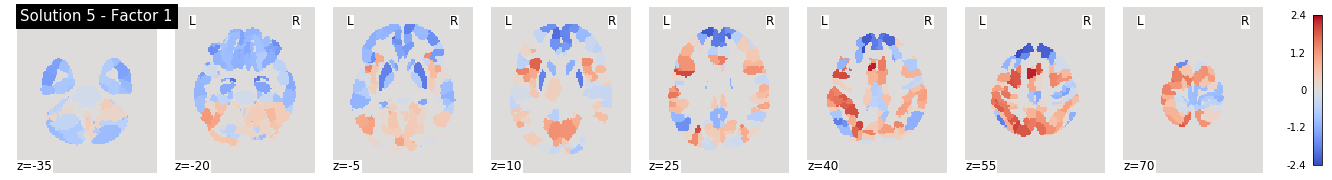

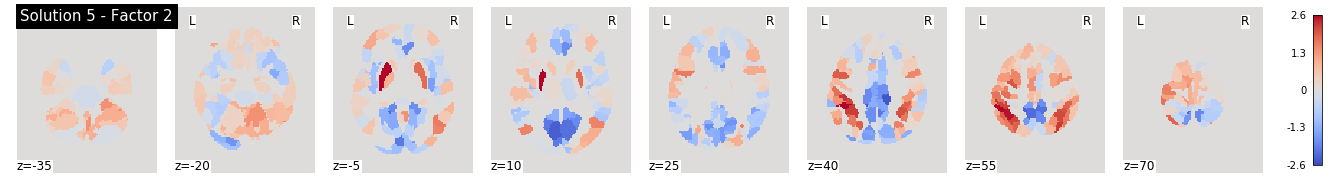

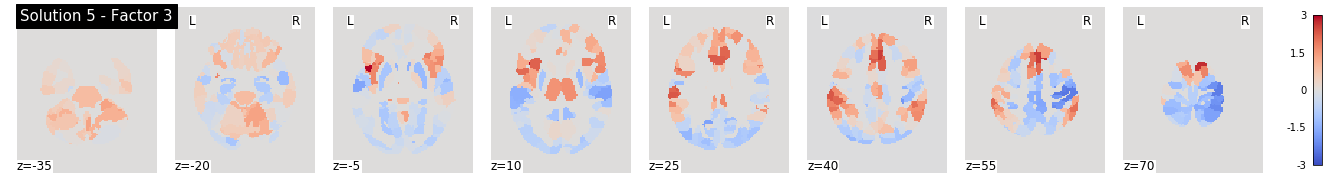

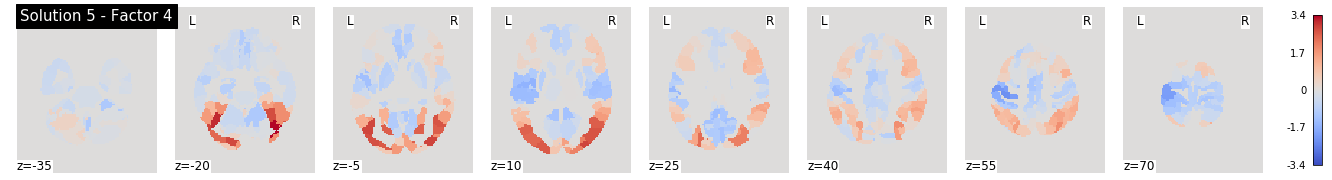

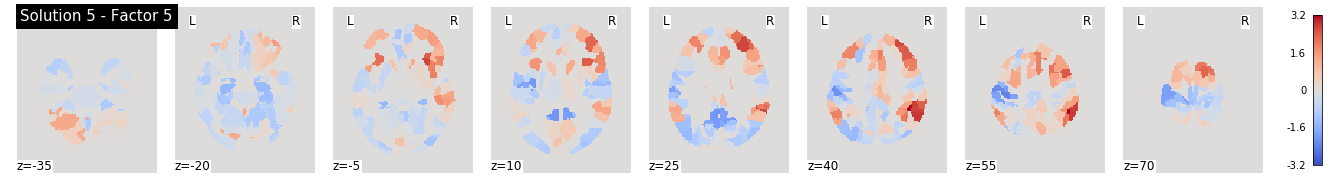

In [17]:
info_dict, BIC_df = pipeline([i for i in ALL_BETA_MAPS if ('task' not in i) and ('trial' not in i)], split_str=SPLIT_STR)

## ALL CONTRASTS - TASKS INCLUDED

****************************************
** Successfully transformed 1 positively skewed variables:
twoByTwo_cue_switch_cost
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 23 contrasts which were correlated above 0.85
twoByTwo_task	twoByTwo_task_stay_cue_switch	twoByTwo_task_switch	twoByTwo_cue_stay	motorSelectiveStop_task	twoByTwo_task_stay_cue_switch_900	twoByTwo_task_switch_900	stopSignal_task	DPX_task	twoByTwo_cue_stay_900	motorSelectiveStop_crit_stop_success	motorSelectiveStop_go_RT	DPX_AY	twoByTwo_task_switch_100	stopSignal_stop_failure	motorSelectiveStop_crit_go	stopSignal_stop_failure-go	motorSelectiveStop_crit_stop_success-crit_go	motorSelect

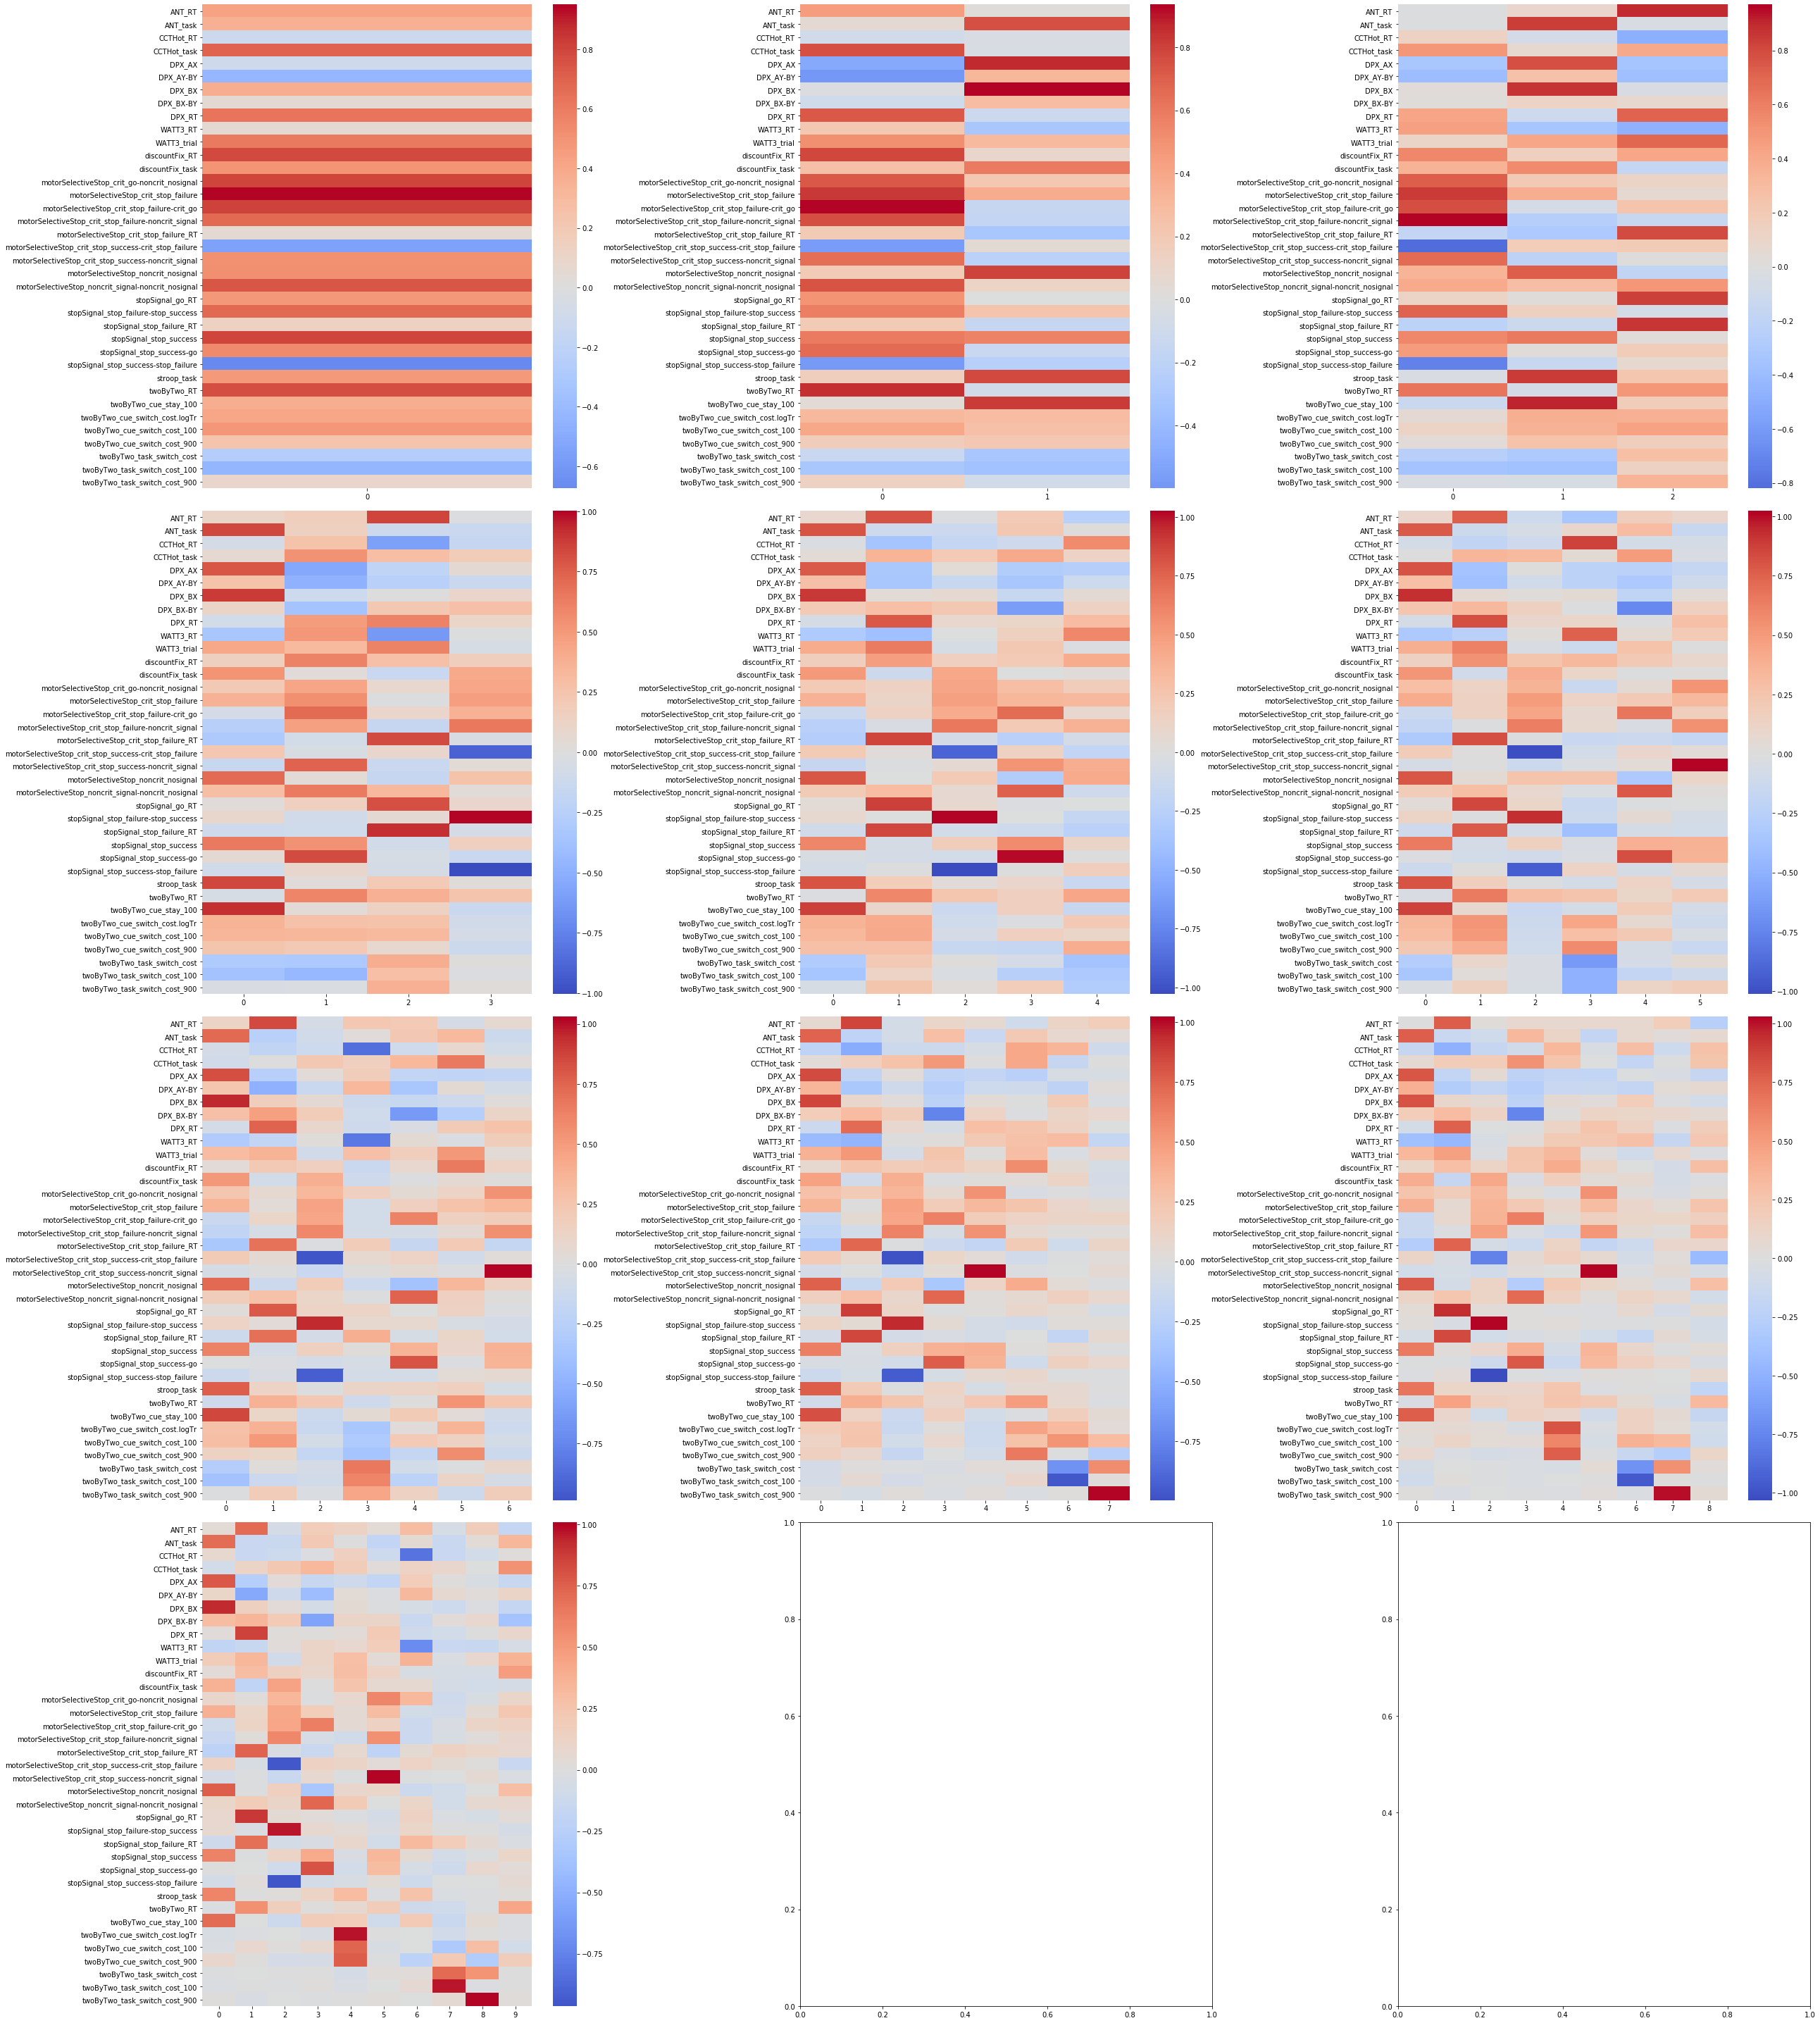

esfMRI [9] [10093.89872504]
400 [10] [8111.9694593]
500 [10] [10953.2856702]
600 [9] [14473.06558385]
800 [10] [20539.65665706]
1000 [10] [25897.78083994]


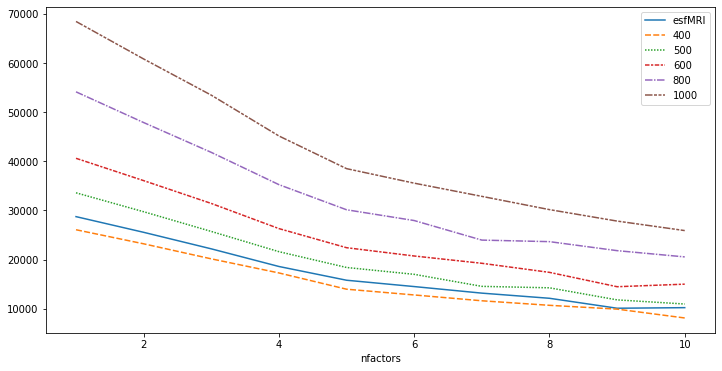

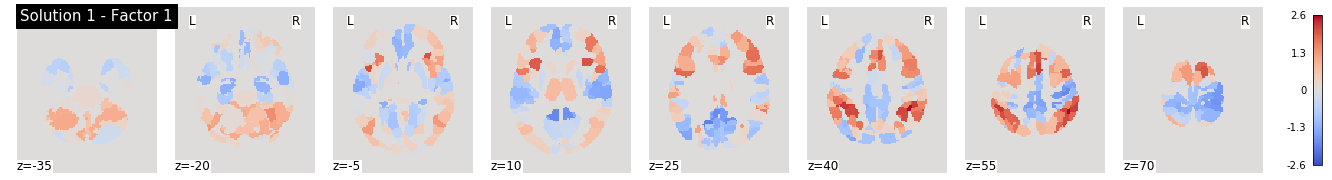

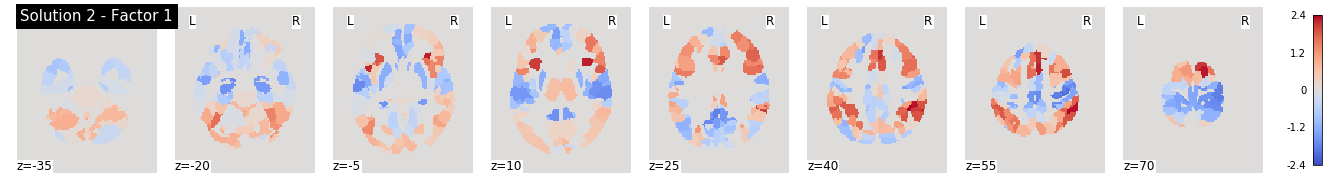

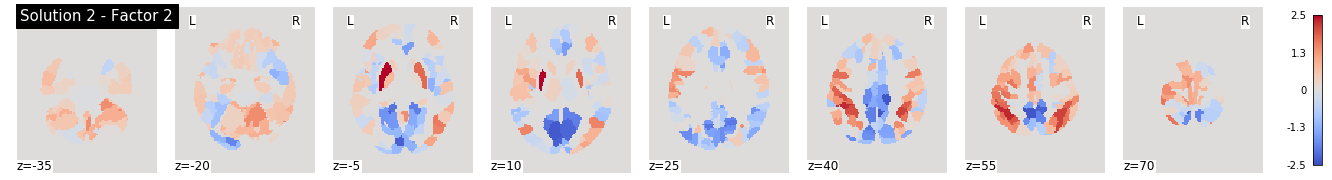

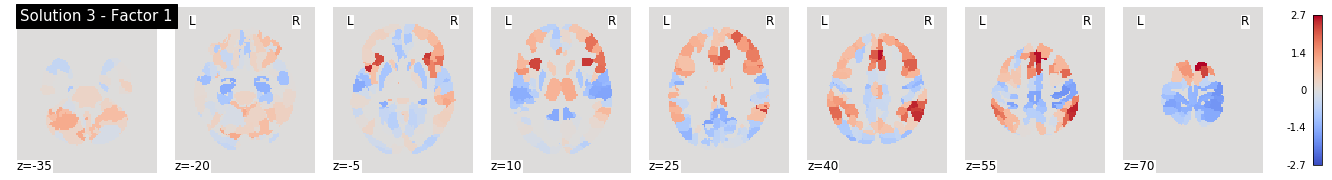

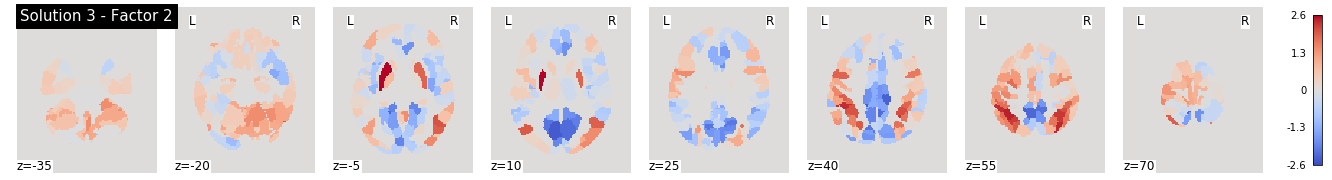

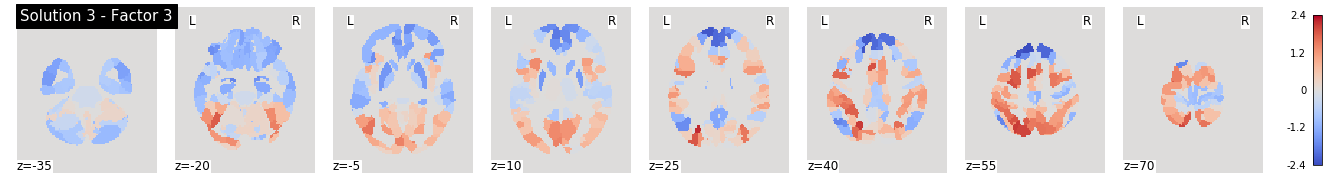

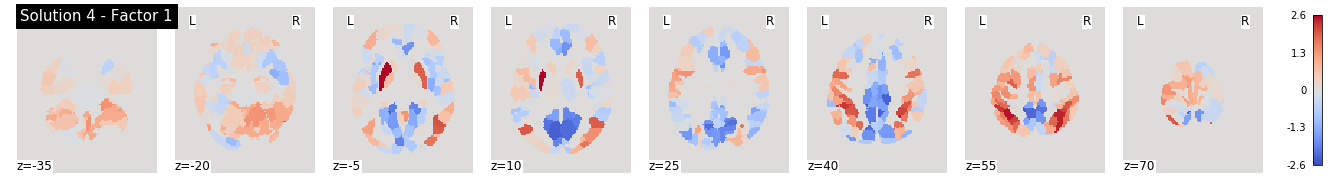

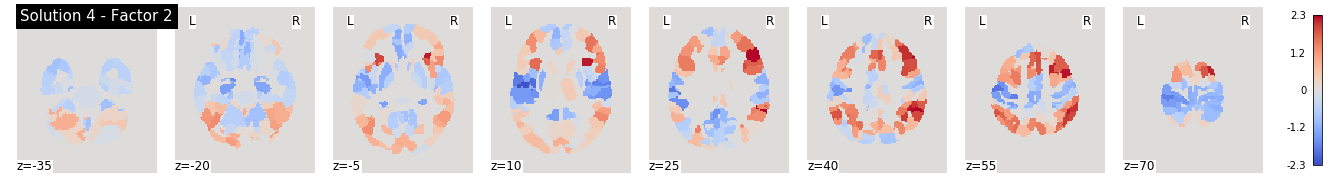

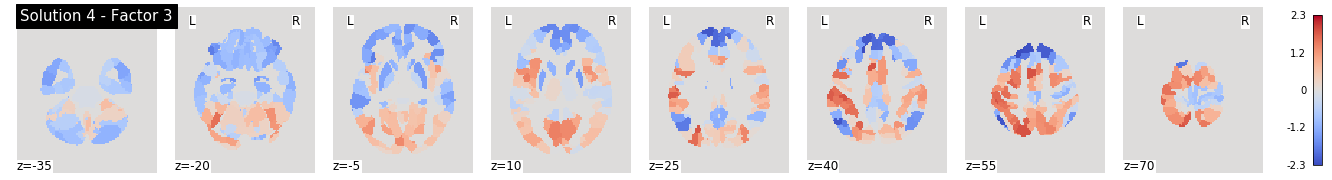

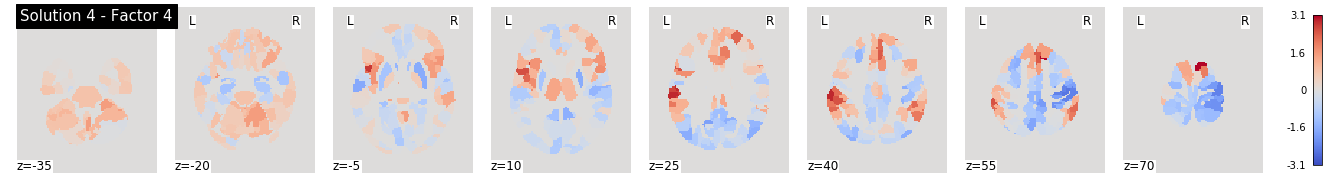

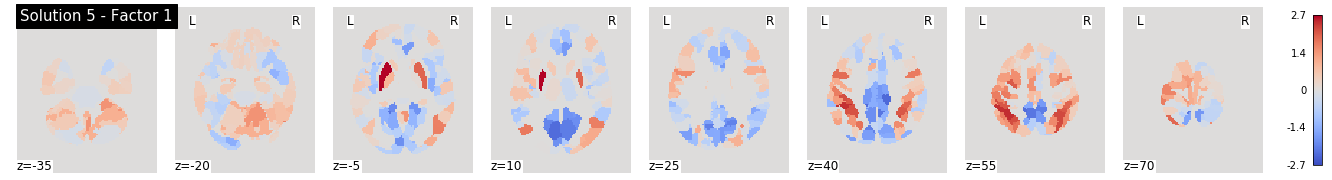

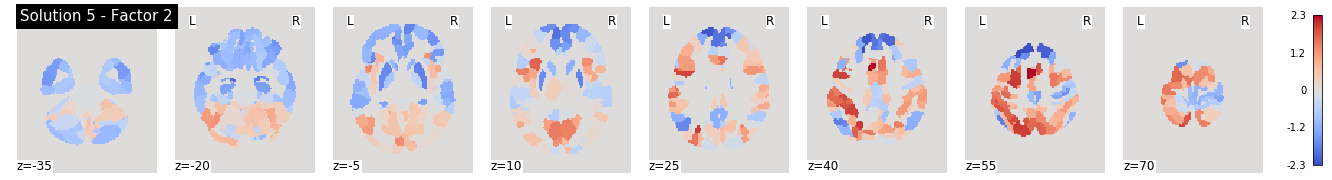

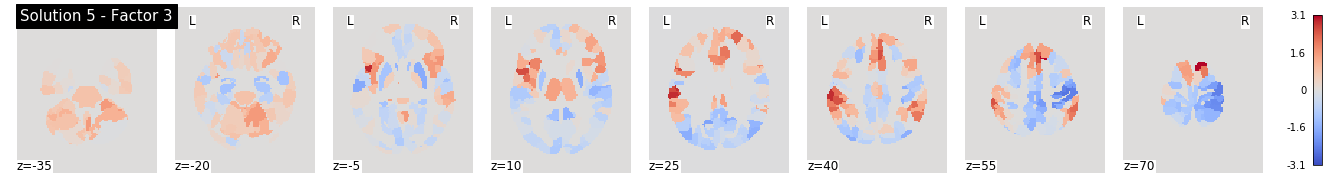

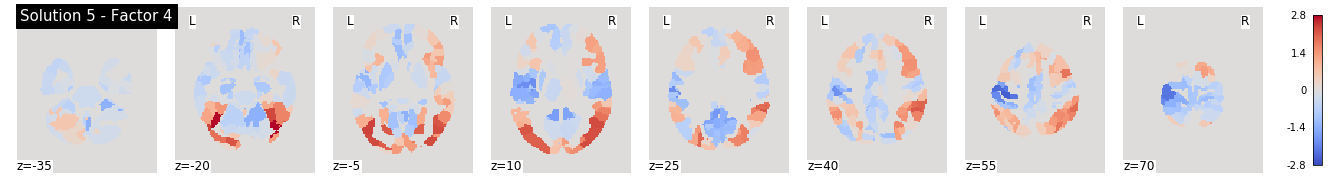

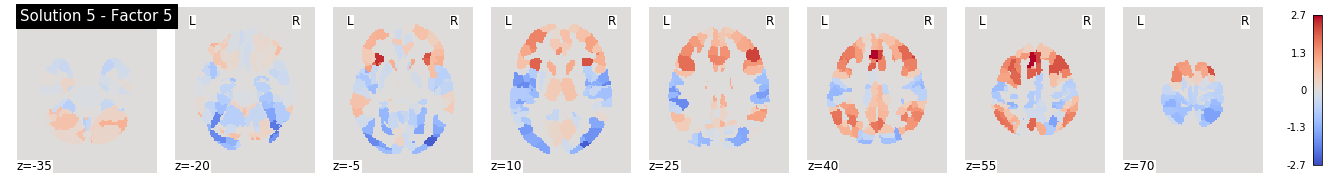

In [18]:
info_dict, BIC_df = pipeline(ALL_BETA_MAPS, split_str=SPLIT_STR)

## ALL CONTRASTS - NO EXCLUSIONS

****************************************
** Successfully transformed 1 positively skewed variables:
twoByTwo_cue_switch_cost
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:


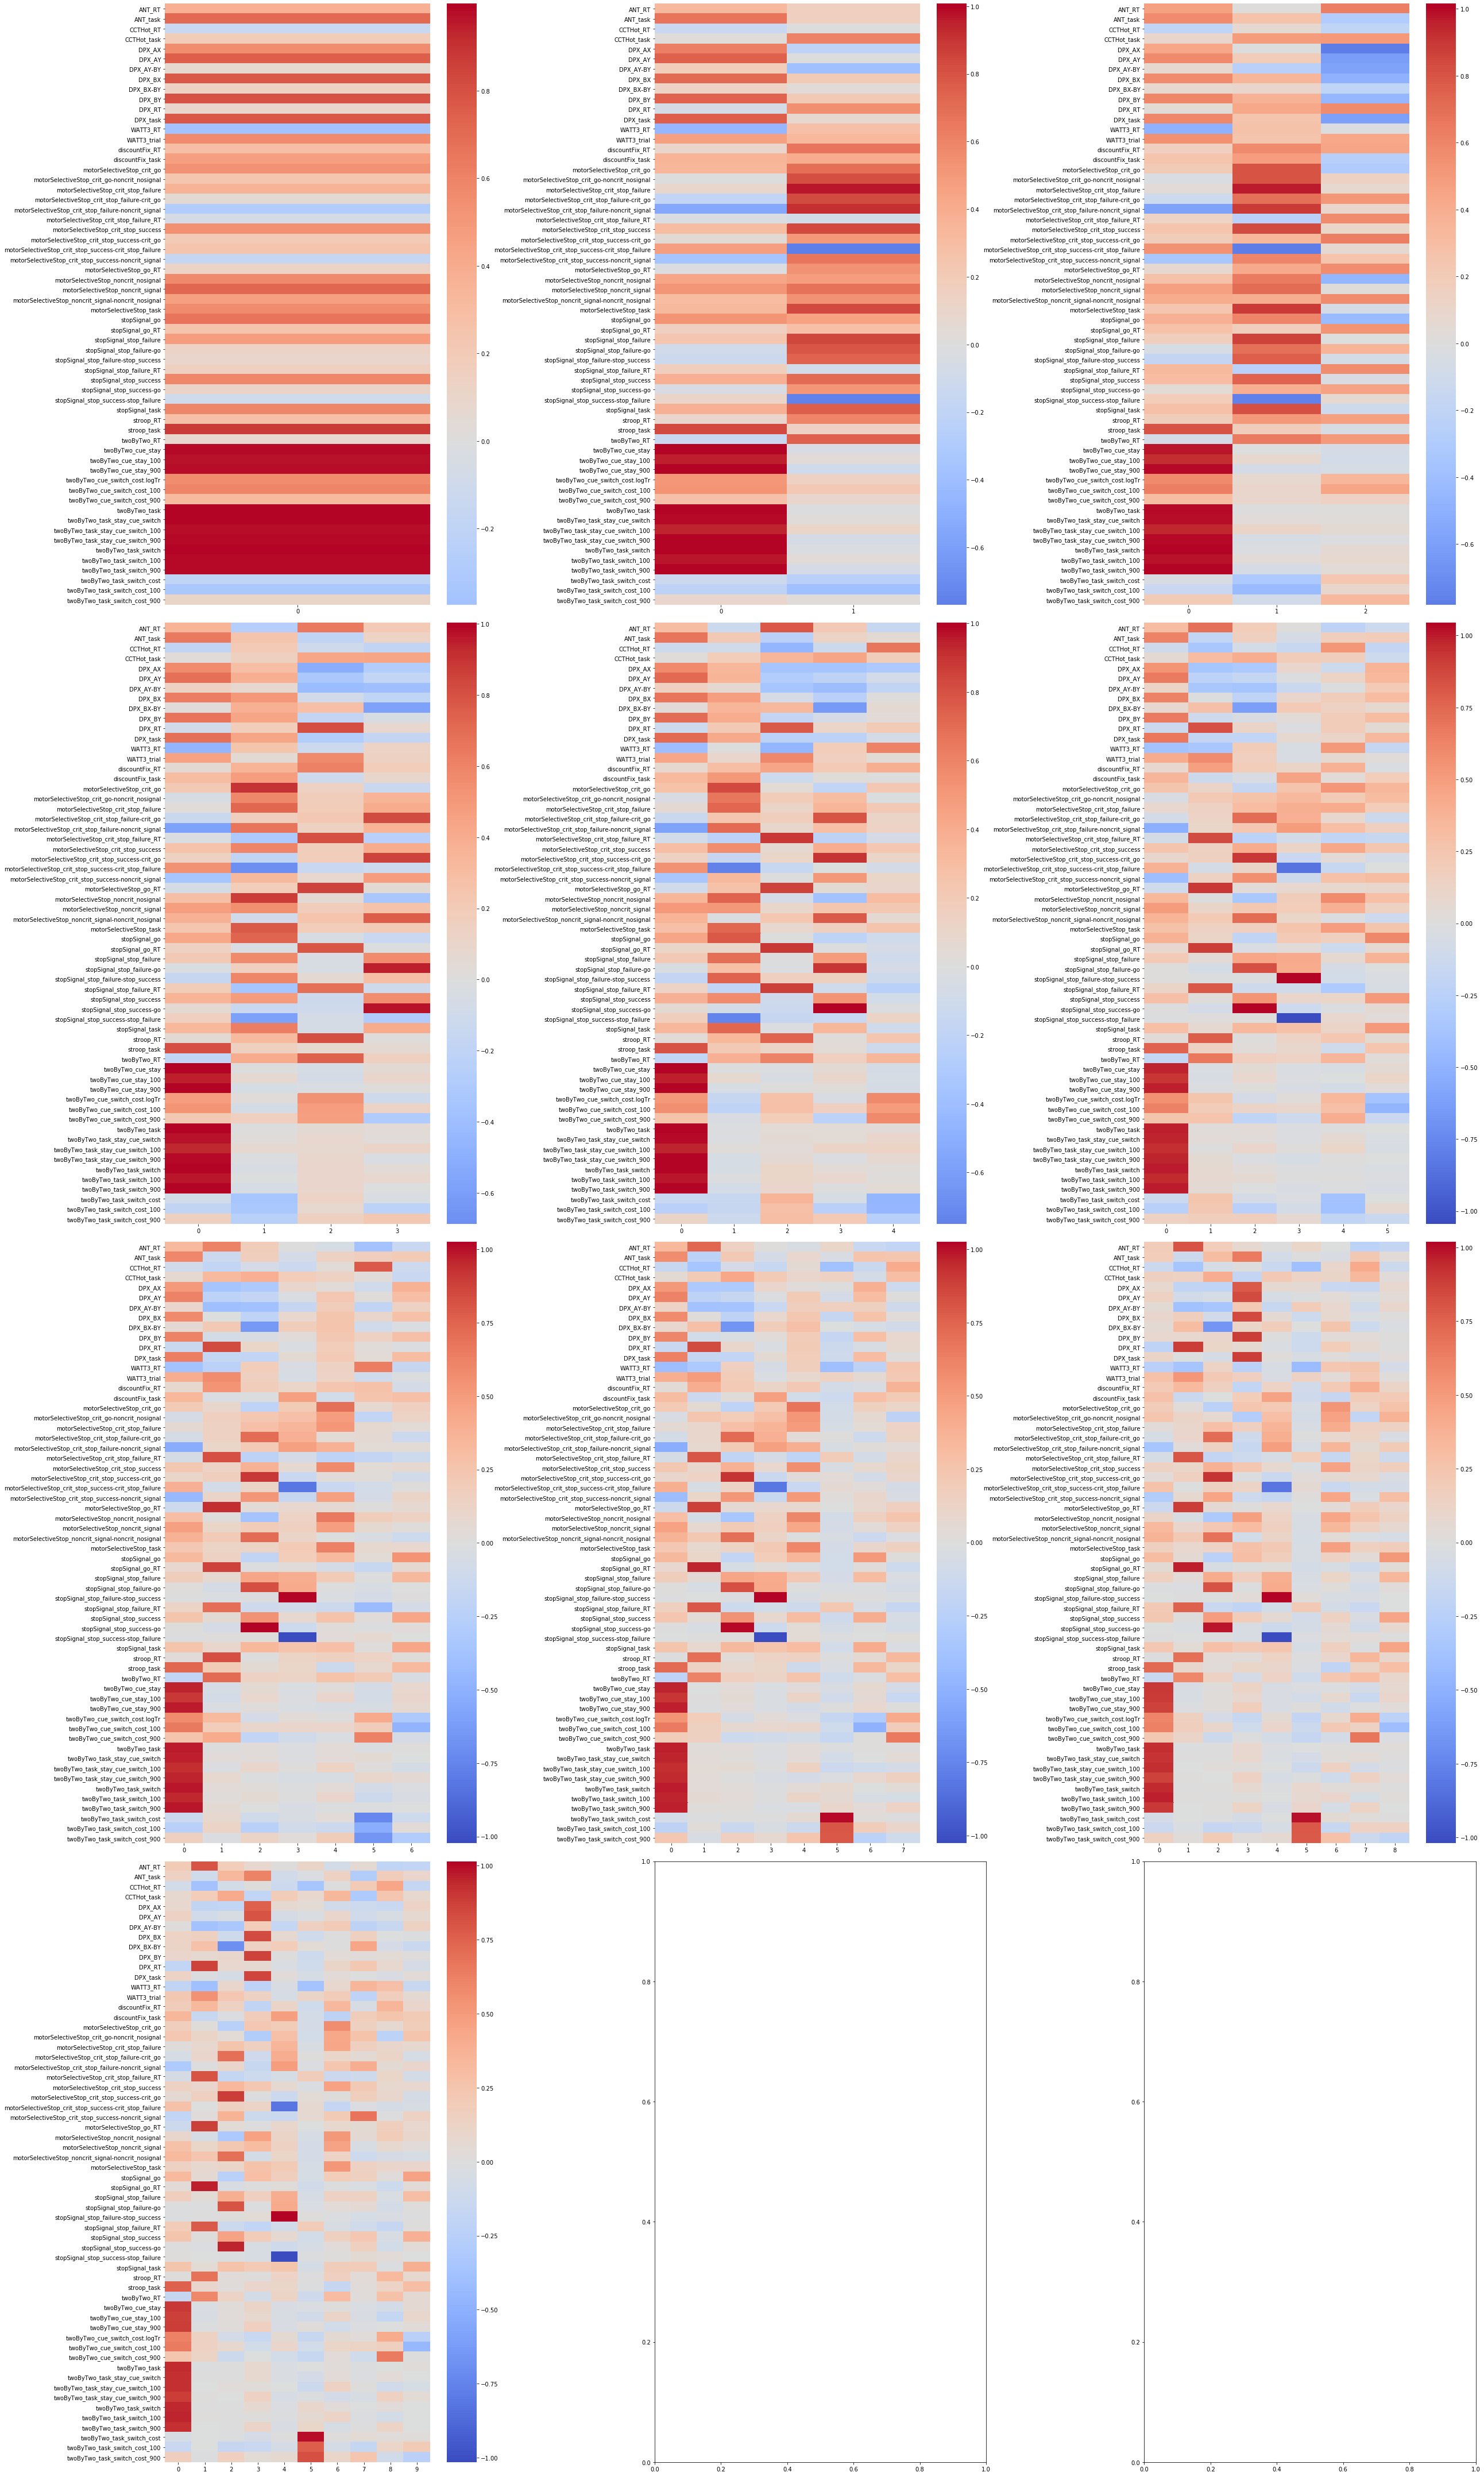

esfMRI [10] [23588.73115655]
400 [10] [21456.08192711]
500 [10] [28044.25632606]
600 [10] [34585.32839964]
800 [10] [47552.08121402]
1000 [10] [60717.40763345]


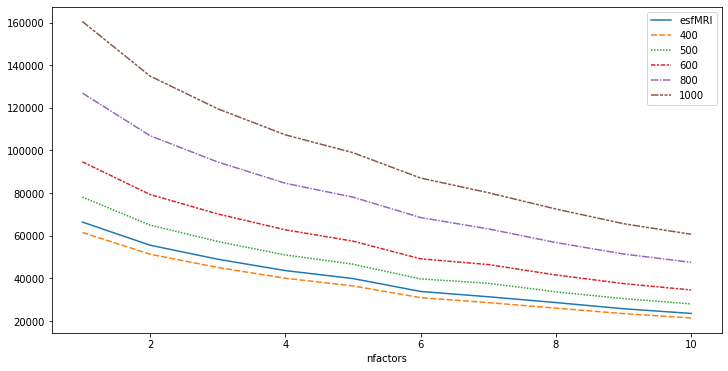

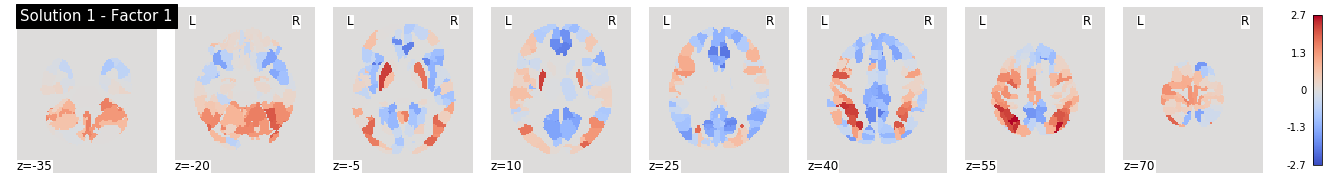

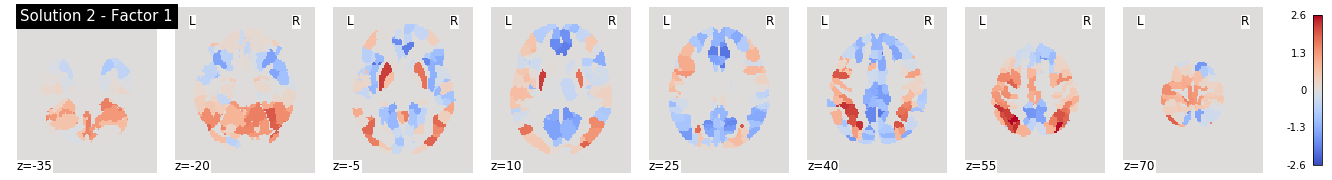

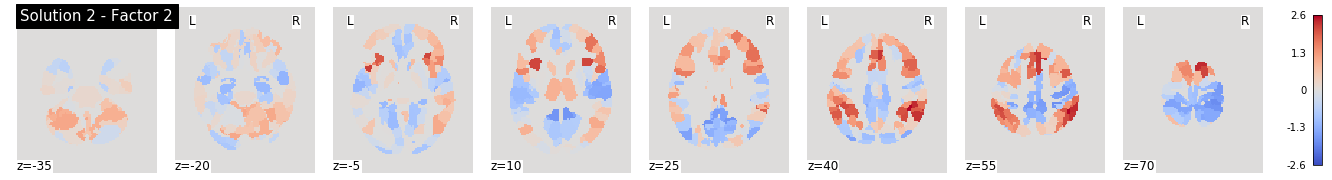

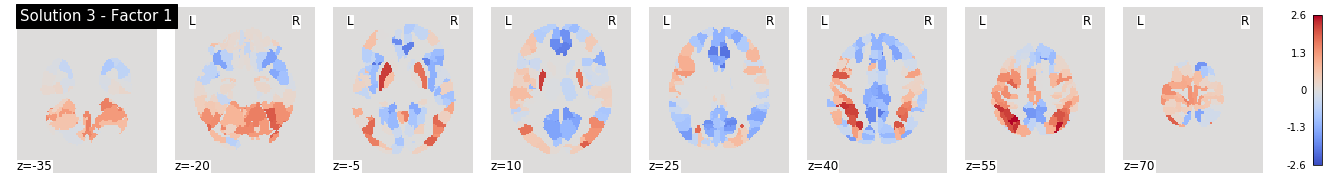

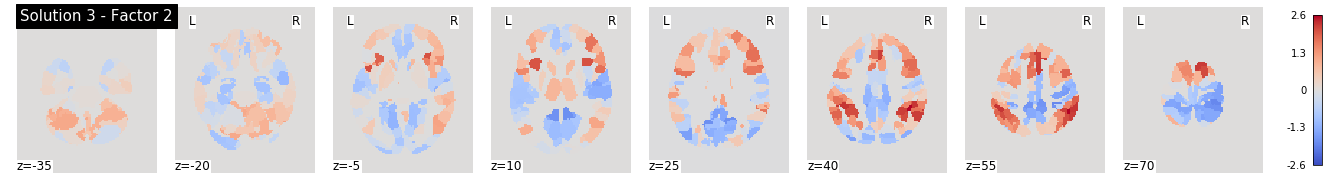

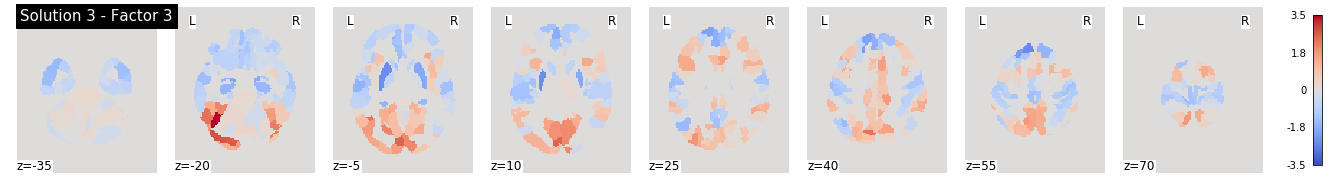

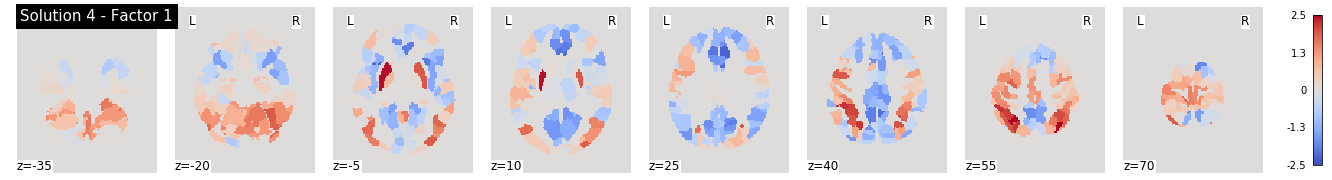

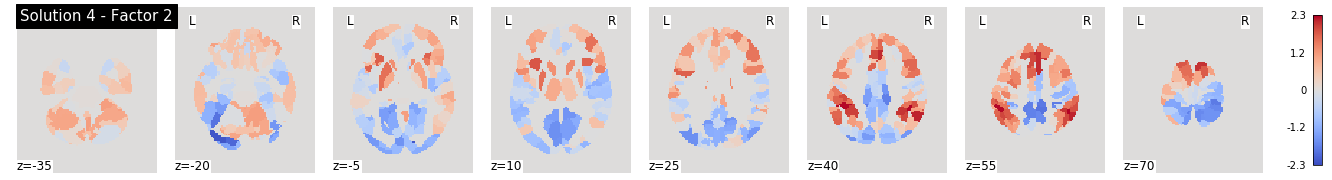

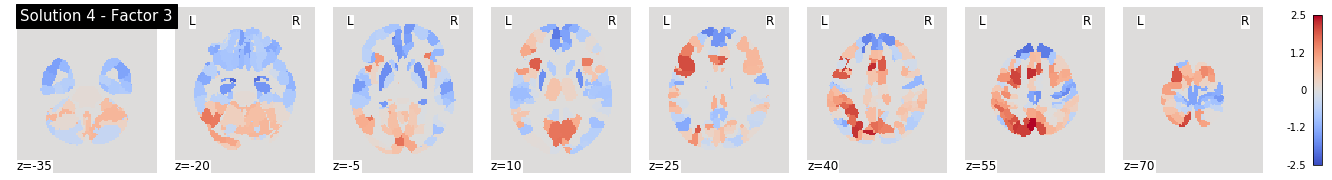

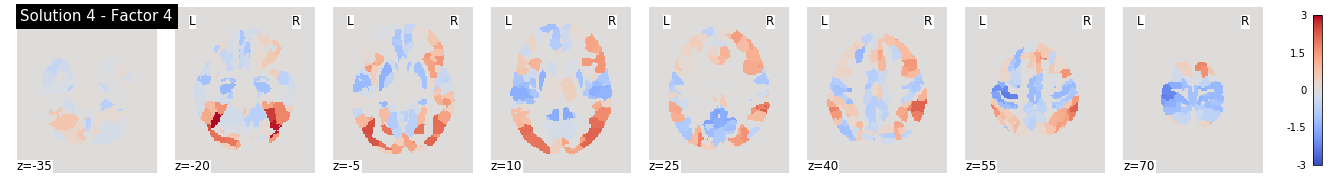

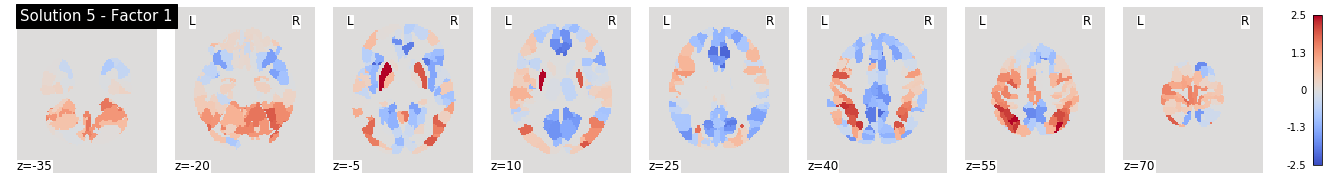

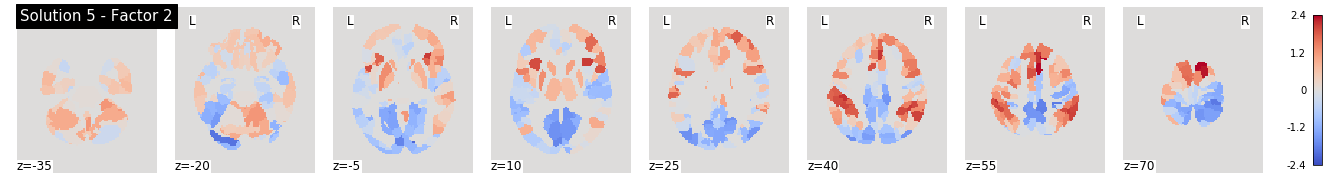

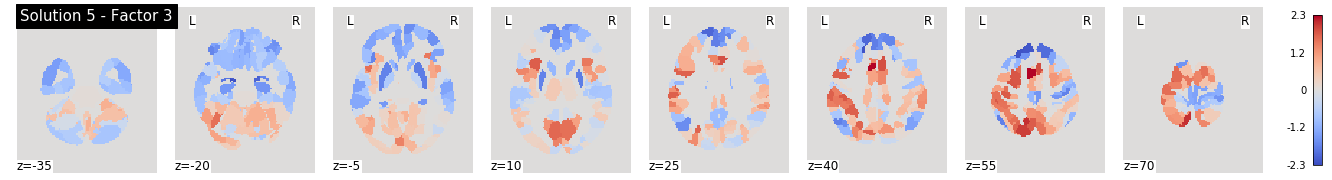

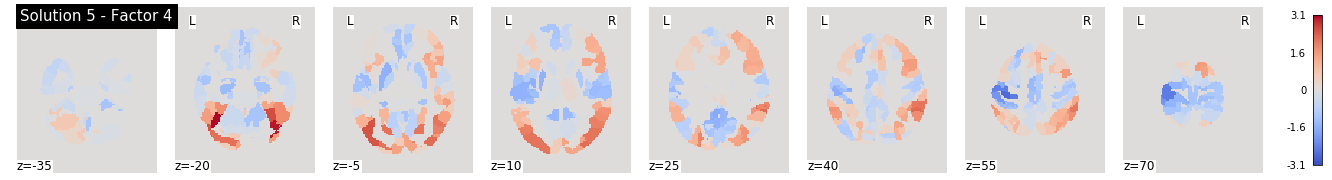

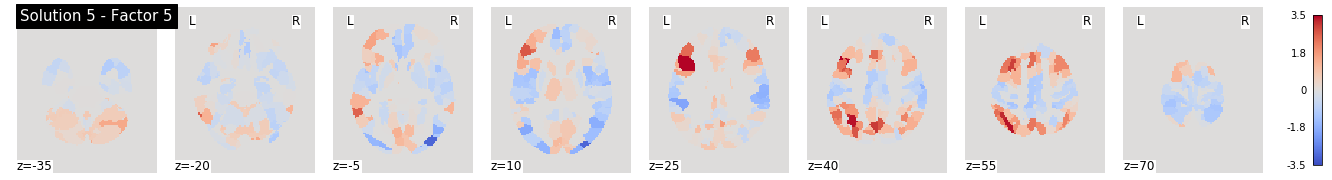

In [19]:
info_dict, BIC_df = pipeline(ALL_BETA_MAPS, split_str=SPLIT_STR, check_correlations=False)